# Introduction

This [Jupyter notebook](https://jupyter.org/), with code written in the [Python language](https://www.python.org/), contains the calculations of all results presented in Section 3 of our article. The code is validated in Supporting Materials 2. There are two levels of commentary, as illustrated in the following code cell.

In [1]:
"""
This is a high-level description of what...
Nothing is calculated in this cell.
"""
# This is a low-level explanation of how...
# Execute the `pass` instruction, which does nothing.
pass

The comments are profuse, but readers unfamiliar with Numeric Python ([NumPy](https://numpy.org/)) array processing may find the code difficult to follow. Hence we include an appendix explaining the NumPy methods that we use. In any case, we recommend ignoring the code cells on a first pass over the notebook.

For convenience in describing the calculations, we express the infinite-population model in matrix form, as Basener and Sanford do in [Section 4](https://doi.org/10.1007/s00285-017-1190-x#Sec12) of their article. There are $n$ classes of organism, and the frequency distribution of organisms over the classes at time $t \geq 0$ is represented as a vector

$$\mathbf{P}(t) = 
   \begin{bmatrix}
      P_1(t) \\ P_2(t) \\ \vdots \\ P_n(t)
   \end{bmatrix}.$$

Annoyingly, the "frequencies" $P_i(t)$ range over the non-negative real numbers, with 

$$0 < \lVert \mathbf{P}(t) \rVert_1 = \sum_i P_i(t) < \infty,$$

while the model assumes that each class contains infinitely many organisms, if any at all. We avoid inconsistency by reporting only relative frequencies $P_i(t) \:\! / \:\! \lVert \mathbf{P}(t) \rVert_1.$ The rate of death of organisms in class $i$ is $d_i P_i(t),$ and the  rate of birth to organisms in class $i$ is $b_i P_i(t).$  Offspring of parents in class $j$ belong to class $i$ with probability $f_{ij},$ and the rate of birth of organisms in class $i$ is $\sum_j b_j f_{ij} P_j(t).$ Evolution is modeled by the differential equation

$$\mathbf{P}^\prime\!(t) = W \mathbf{P}(t),$$

with elements of the square matrix $W$ defined

\begin{equation*}
   w_{ij} := 
      \begin{cases}
          b_j f_{ij} - d_j &\text{if }i = j \\
          b_j f_{ij} &\text{otherwise.}
      \end{cases}
\end{equation*}

Writing $\mathbf{w}_i$ for the $i$-th row of $W\!,$

$$\frac{\text{d}P_i(t)}{\text{d}t} = P^\prime_i\!(t) = \mathbf{w}_i \mathbf{P}(t).$$

In the ensuing sections, we address the settings of model parameters, demonstrate that a modification of the model, addressed in [Section 5](https://doi.org/10.1007/s00285-017-1190-x#Sec13) of Basener and Sanford, is extremely unrealistic, and obtain equilibrium distributions for the (unmodified) model with various parameter settings. The following code cell initializes the Python environment in which calculations are performed.

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp
"""
Supporting general-purpose code is not listed here, but is listed, and
also tested, in Supporting Materials 2.
"""
%run -i ./Code/graphics.py
%run -i ./Code/utilities.py
"""
Figures are non-interactive. They are saved in subdirectory ./Figures/
of the directory containing this notebook.
"""
plt.interactive(False)
DIR = './Figures/'
"""
Set the default number of digits of precision for multiprecision
floating-point operations.
"""
mp.dps = 50
"""
Indicate when this code cell was last executed.
"""
from datetime import datetime
print("Time stamp:", datetime.now())

Time stamp: 2020-06-24 00:13:15.541718


# Parameter settings

We follow [Section 5.4](https://doi.org/10.1007/s00285-017-1190-x#Sec17) of Basener and Sanford in the following:

* bin width $w = 0.0005,$
* birth parameter $b_i = (i - 1)w,$ $i = 1, 2, \dotsc, n,$
* death parameter $d_i = d = 0.1,$  $i = 1, 2, \dotsc, n,$
* fitness (Malthusian parameter) $m_i = b_i - d,$  $i = 1, 2, \dotsc, n,$
* initial frequency distribution $\mathbf{P}(0)$ is defined in terms of a binned Gaussian distribution (mean 0.044, standard deviation 0.005) of probability over fitness, and
* probabilities $f_{ij}$ are defined in terms of a binned mixture of a Gamma distribution (shape $\alpha=0.5,$ rate $\beta=500$) and its reflection.

Basener and Sanford set the number of classes $n=500,$ but we generate results for various settings of the parameter. We specify $n$ indirectly, stating the maximum fitness $m_\text{max} = b_\text{max} - d,$ where $b_\text{max} = (n-1) w$ is the maximum of the birth parameters. It follows that

\begin{equation*}
   n = \frac{ b_\text{max} }{ w } + 1.
\end{equation*}

A class is not necessarily a single genotype, and thus a mutant may be identical in class to its parent. That is, a mutation does not necessarily change fitness. The model does not distinguish nonmutants from mutants that are identical in class to their parents. For simplicity, we refer to the difference in fitness of the class of an organism and the class of its parent as the effect of mutation on fitness, or as the mutational effect. When the parent is in class $j,$ there are $n$ possible effects of mutation on fitness,

\begin{align*}
   \mathcal{E}_j 
      &= \{m_i - m_j \mid i \in \{1, 2, \dotsc, n\} \} \\
      &= \{(i - j) w \mid i \in \{1, 2, \dotsc, n\} \} \\
      &= \{(1 - j) w, (2 - j)w, \dotsc, (n - j)w \},
\end{align*}

including zero mutational effect. According to [Section 3.1](https://doi.org/10.1007/s00285-017-1190-x#Sec10) of Basener and Sanford, 

>\[T\]he probability that the progeny of a parent with fitness $m_j$ has fitness $m_i$ is given by a probability distribution function $f_{ij}.$ It is assumed that this the \[*sic*\] distribution is a function of $(m_i - m_j)$; that is, it depends on the difference in fitness from parent to offspring and not on the particular genotype of the parent.

That is, $f_{ij} = q(m_i - m_j),$ where function $q(\cdot)$ is a distribution of probability over

\begin{align*}
\mathcal{E}
   &= \mathcal{E}_1 \cup \mathcal{E}_2 \cup \cdots \cup \mathcal{E}_n \\
   &= \{m_i - m_j \mid i, j \in \{1, 2, \dotsc, n\}  \} \\
   &= \{(i - j)w \mid i, j \in \{1, 2, \dotsc, n\}  \} \\
   &= \{(1 - n)w, \ldots, -w, 0, w, \dotsc, (n - 1)w \}.
\end{align*}

However, this definition is inconsistent with the requirement that $f_{ij}$ be the probability that a birth to a parent in class $j$ belongs to class $i.$ With $q(x) > 0$ for all $2n - 1$ of the mutational effects $x$ in $\mathcal{E},$ as in [Section 5](https://doi.org/10.1007/s00285-017-1190-x#Sec13) of Basener and Sanford,

\begin{align*}
   \sum_{i=1}^n f_{ij} 
      &= \sum_{i=1}^n q(m_i - m_j) \\
      &= \sum_{x \in \mathcal{E}_j} q(x) \\
      &< \sum_{x \in \mathcal{E}} q(x) \\
      &= 1
\end{align*}

for all parental classes $j.$ The strict inequality holds because $\mathcal{E}_j$ is a strict (proper) subset of the support $\mathcal{E}$ of the discrete probability distribution $q.$ We eliminate the inconsistency by setting

\begin{align*}
   f_{jj} 
      &= 1 - \sum_{i \neq j} f_{ij} \\
      &= q(0) + \sum_{x \notin \mathcal{E}_j} q(x)
\end{align*}

for $j = 1, 2, \dotsc, n.$ That is, the probabilities of nonzero mutational effects do not depend on the class of the parent, as stipulated by Basener and Sanford, but the probability of zero mutational effect does depend on the class of the parent. The probabilities of beneficial and deleterious mutation also depend on the class of the parent. For parents in class $j,$ the probability of beneficial mutation is

$$\sum_{i > j} f_{ij} = \sum_{i > j} q(m_i - m_j) 
                      \leq \sum_{i=1}^{n-1} q(i\:\! w),$$
                      
with equality throughout only if $j=1,$ and the probability of deleterious mutation is

$$\sum_{i < j} f_{ij} = \sum_{i < j} q(m_i - m_j) 
                      \leq \sum_{i=1}^{n-1} q(-i\:\! w),$$
                      
with equality throughout only if $j=n.$ The probability of beneficial (deleterious) mutation is a monotonically decreasing (increasing) function of the class index $j$ of the parent. For births to parents in class $1,$ the probability of deleterious mutation is zero, and for births to parents in class $n,$ the probability of beneficial mutation is zero.
                      
Now we address the definition of probabilities $f_{ij}$ in terms of a weighted mixture of a Gamma distribution and its reflection. Note at the outset that the tails of the mixture distribution (over the real numbers) will be truncated, with the truncation depending on the class of the parent. In [Equation 5.1](https://doi.org/10.1007/s00285-017-1190-x#Equ16) of their article, Basener and Sanford equate $f_{ij}$ with $g(m_i - m_j),$ where $g$ is the probability density function of the Gamma distribution with shape $\alpha = 0.5$ and rate $\beta = 500.$ This is multifariously wrong:

* A probability mass, not a density, is required for $f_{ij}.$
* The density $g(m_i - m_j)$ is undefined for $m_i \leq m_j.$
* The weightings of the Gamma distribution and its reflection are absent.

The probability density function of a weighted mixture of the Gamma distribution and its reflection is

\begin{align*}
    g_\gamma(x) =
       \begin{cases}
          \gamma g(x) & \text{ if } x > 0 \\
          (1-\gamma) g(-x) & \text{ if } x < 0,
       \end{cases}
\end{align*}

where $\gamma \in [0, 1]$ is the mixture weight. The corresponding cumulative distribution function is

\begin{equation*}
   G_\gamma(x) = 
      \begin{cases}
         (1 - \gamma) (1 - G(-x)) &\text{ if } x \leq 0 \\
         \gamma G(x) + 1 - \gamma &\text{ otherwise,}
      \end{cases}
\end{equation*}

where $G$ is the cumulative distribution function of the Gamma distribution. Basener and Sanford address only the case of $\gamma = 10^{-3},$ but we generate results for various mixture weights, and thus write $q_\gamma$ in place of $q.$ For all $x$ in $\mathcal{E},$ we set $q_\gamma(x)$ to the normalized probability mass of the width-$w$ bin (interval) centered on $x,$ i.e.,

\begin{equation*}
    q_\gamma(x) 
       =  \frac{ G_\gamma(x+w/2) - G_\gamma(x-w/2) } 
               { \sum_{z \in \mathcal{E}} 
                   G_\gamma(z+w/2) - G_\gamma(z-w/2) }.
\end{equation*}

The value of $q_\gamma(0)$ does not depend on $\gamma,$ because

\begin{align*}
   G_\gamma(w/2) - G_\gamma(-w/2)
      &= \gamma G(w/2) + (1 - \gamma) - (1 - \gamma) (1 - G(w/2)) \\
      &= \gamma G(w/2) + (1 - \gamma) G(w/2) \\
      &= G(w/2).
\end{align*}

Note that Basener's software approximates $q_\gamma(x)$ as $w\:\!g_\gamma(x)$ for $x \neq 0,$ but unjustifiably sets $f_{jj},$ the probability of zero mutational effect, to $w\:\!g_\gamma(-w),$ the probability of the minimally deleterious effect. As shown in Supporting Materials 3, the consequence is that 45 percent of offspring identical in class to their parents are discarded.

The initial frequency of class $i$ is

\begin{equation*}
P_i(0) = \frac{F(m_i + w/2) - F(m_i - w/2)}
              {\sum_{j=1}^n F(m_j + w/2) - F(m_j - w/2)},
\end{equation*}

where $F$ is the cumulative distribution function of the Gaussian distribution with mean 0.044 and standard deviation 0.005.

In the following code cell, a Python class `Parameters` is defined. An instance of the class contains all of the parameters consistent with given maximum birth parameter `b_max`, death parameter `d`, bin width `w`, and mixture weight `gamma`. The definition is simpler than it appears at first glance: there are only 41 lines of code.

In [3]:
# %load ./Code/parameters.py
class Parameters(object):
    """
    Stores all parameter settings of the infinite-population model.    
    
    There are correspondingly named members for model parameters b, d,
    m, w, gamma, n, and W. Instance method `q()` returns the
    probability distribution over mutational effects, and class method
    `f()` returns the corresponding matrix.
    
    All numbers, other than integer `n`, are multiprecision floats.
    """
    def __init__(self, b_max='0.25', d='0.1', w='5e-4', gamma='1e-3'):
        """
        Sets all parameters of the infinite-population model.
        
        Parameters are derived from the maximum birth parameter 
        `b_max`, the death parameter `d`, the bin width `w`, and the
        weighting `gamma` of beneficial mutational effects. The number
        `n` of classes of organism is set to the integer nearest to 
        `b_max/w + 1`.
        
        The default parameter settings come from Section 5 of Basener
        and Sanford.
        """
        # Use `mp_float()` for explicit conversion to multiprecision
        # float. In mixed-mode operations, (arrays of) integers and
        # floats are promoted automatically to (arrays of) multi-
        # precision floats.
        b_max = mp_float(b_max)
        self.d = mp_float(d)
        self.w = mp_float(w)
        self.gamma = mp_float(gamma)
        #
        # The number of classes is 1 plus the integer nearest to
        # `b_max / w`.
        self.n = int(mp.nint(b_max / self.w)) + 1
        #
        # Create an array of n evenly spaced birth parameters ranging
        # from 0 to `b_max`.
        self.b = np.array(mp.linspace(0, b_max, self.n))
        #
        # Subtract the scalar death parameter `d` from all elements of
        # the array of birth parameters to get the array of fitnesses.
        self.m = self.b - self.d
        #
        # To obtain the derivative operator `W`, first scale the
        # columns of the matrix `f()` (probabilities of mutational
        # effects) by the corresponding birth parameters, and then
        # subtract the death parameter from the elements of the main
        # diagonal.
        self.W = self.f(self.q(self.gamma)) * self.b
        self.W[np.diag_indices(self.n)] -= self.d
        
    @staticmethod
    def f(q):
        """
        Returns the matrix of probabilities of mutational effects.
        
        The given probability distribution (1-D array) `q` contains
        2n - 1 non-negative numbers summing to 1. 
        
        The returned matrix `f` is n-by-n. Each off-diagonal element
        `f[i,j]` is set to `q[n-1+i-j]`. Each element `f[j,j]` is set
        to make the sum of elements in column `j` equal to 1.
        """
        n = (len(q) + 1) // 2
        f = np.empty((n, n), dtype=object)
        for j in range(n):
            for i in range(n):
                f[i,j] = q[(n-1) + (i-j)]
            f[j,j] += 1 - fsum(f[:,j])
        return f
    
    def q(self, gamma, beta=500):
        """
        Returns a probability distribution over mutational effects.
        
        Writing w for `self.w`, the bin width, and n for `self.n`,
        the number of classes of organism, the mutational effects
        are 
        
            (1-n)w, ..., -w, 0, w, ..., (n-1)w.
        
        The unnormalized probability of mutational effect x is 
        
            G(x + w/2) - G(x - w/2),
        
        where G is the cumulative distribution function of the
        weighted mixture of a Gamma distribution (shape alpha=0.5,
        rate `beta`) and its reflection. The weighting of the Gamma
        distribution in the mixture is `gamma`, a number in the
        closed interval [0, 1]. The default value of `beta` comes
        from Section 5 of Basener and Sanford.
        
        The returned probability distribution (array) is normalized.
        """
        # The walls of the width-w bins centered on the n - 1 positive
        # mutational effects are n evenly spaced points ranging from
        # (1-1/2)w to (n-1/2)w, i.e., the birth parameters plus w/2.
        walls = self.b + self.w/2
        
        # Calculate bin masses by differencing values of the comple-
        # mentary CDF of the Gamma distribution at the bin walls. 
        # The slice [:-1] of an array includes all elements but the
        # last, and the slice [1:] includes all elements but the first.
        # Note that alpha=0.5 is a special case. 
        complementary_cdf = erfc((beta * walls) ** 0.5)
        masses = complementary_cdf[:-1] - complementary_cdf[1:]
        #
        # The mass of the bin centered on zero is the value of the 
        # Gamma CDF at w/2 == walls[0].
        zero_mass = 1 - complementary_cdf[0]
        #
        # The upper (lower) tail of the binned mixture is obtained by
        # weighting the (reversed) `masses`.
        upper_tail = gamma * masses
        lower_tail = (1 - gamma) * masses[::-1]
        #
        # Assemble the pieces into a single array, and normalize.
        q = np.concatenate((lower_tail, [zero_mass], upper_tail))
        return q / fsum(q)

    def initial_freqs(self, mean='0.044', std='0.005'):
        """
        Returns a binned normal distribution over fitness.
        
        The unnormalized probability of fitness `m[i]` is
        
            `F(m[i] + self.w/2) - F(m[i] - self.w/2)`,
            
        where `F` is the cumulative distribution function of the
        normal distribution with the given `mean` and standard
        deviation `std`. The default settings of the parameters come
        from Section 5 of Basener and Sanford.
        
        The returned probability distribution (array) is normalized.
        """
        mean = mp_float(mean)
        std = mp_float(std)
        #
        # The n fitnesses are 0w - d, 1w - d, ..., (n-1)w - d. The
        # n + 1 walls of the width-w bins centered on the fitnesses
        # are (0-1/2)w - d, (1-1/2)w - d, ..., (n-1/2)w - d. Create 
        # an array [-1/2, 1/2, ..., n-1/2], scale all of the elements
        # by w, and then subtract d from all of the elements.
        walls = self.m + self.w/2
        walls = np.concatenate((walls[:1] - self.w, walls))
        #
        # Evaluate the CDF and the complementary CDF at the bin walls.
        # Accuracy is much greater using erfc() than using erf().
        z = (walls - mean) / (std * mp_float(2.0)**0.5)
        cdf = 0.5 * erfc(-z)
        ccdf = 0.5 * erfc(z)
        #
        # Calculate bin masses by differencing CDF values at the bin
        # walls, and also by differencing complementary CDF values at
        # the bin walls. The slice [1:] includes all array elements
        # except the first, and the slice [:-1] includes all array
        # elements except the last.
        per_cdf = cdf[1:] - cdf[:-1]
        per_ccdf = ccdf[:-1] - ccdf[1:]
        #
        # For accuracy, use the CDF differences for bins with upper
        # walls no greater than the mean, and the complementary CDF
        # differences for other bins.
        freqs = np.where(walls[1:] <= mean, per_cdf, per_ccdf)
        return freqs / fsum(freqs)

**More on the probability of beneficial mutation.** Basener and Sanford refer to the mixture weight $\gamma$ as the probability of beneficial mutation. But this is wrong, in part because the probability of beneficial mutation depends on the class of the parent, and may be as small as zero. We prefer the term *beneficial effects weight*. As demonstrated in the following code cell, $q_\gamma(0) \approx .383$ for all $\gamma.$ Thus distribution $q_\gamma$ apportions probability mass $1 - q_\gamma(0) \approx .617$ to the positive and negative mutational effects, with mass $.617 \gamma$ going to positive effects in $\mathcal{E},$ and mass $.617 (1 - \gamma)$ going to negative effects in $\mathcal{E}.$ However, $\mathcal{E}_j \subset \mathcal{E}$ for all $j,$ which is to say that not all of the mutational effects are possible for any particular parental class. As the class index $j$ of the parent increases from $1$ to $n,$ the probability of beneficial mutation, 

$$\sum_{i>j} f_{ij} = \sum_{i>j} q_\gamma(m_i - m_j),$$

decreases from $.617 \gamma$ to zero, and the probability of deleterious mutation, 

$$\sum_{i<j} f_{ij} = \sum_{i<j} q_\gamma(m_i - m_j),$$

increases from zero to $.617 (1-\gamma).$ However, distribution $q_\gamma$ concentrates probability mass so heavily in the vicinity of zero mutational effect that, for the great majority of parental classes, the probabilities of beneficial mutation and deleterious mutation are close to their upper bounds, and the probability of zero mutational effect is just slightly greater than $q_\gamma(0) \approx .383.$ It is reasonable to say that the probability of beneficial mutation is about $.617\gamma,$ except when the class of the parent is nearly maximal in fitness.

In the following code cell, we create four instances of the `Parameters` class, differing only in the setting of $\gamma,$ and verify that the foregoing claims hold. The settings of $\gamma$ are $10^{-3},$ $10^{-6},$ $10^{-9},$ and $10^{-12}.$ 

For all instances...
       q(0) == 0.3829249225480262
   1 - q(0) == 0.6170750774519738


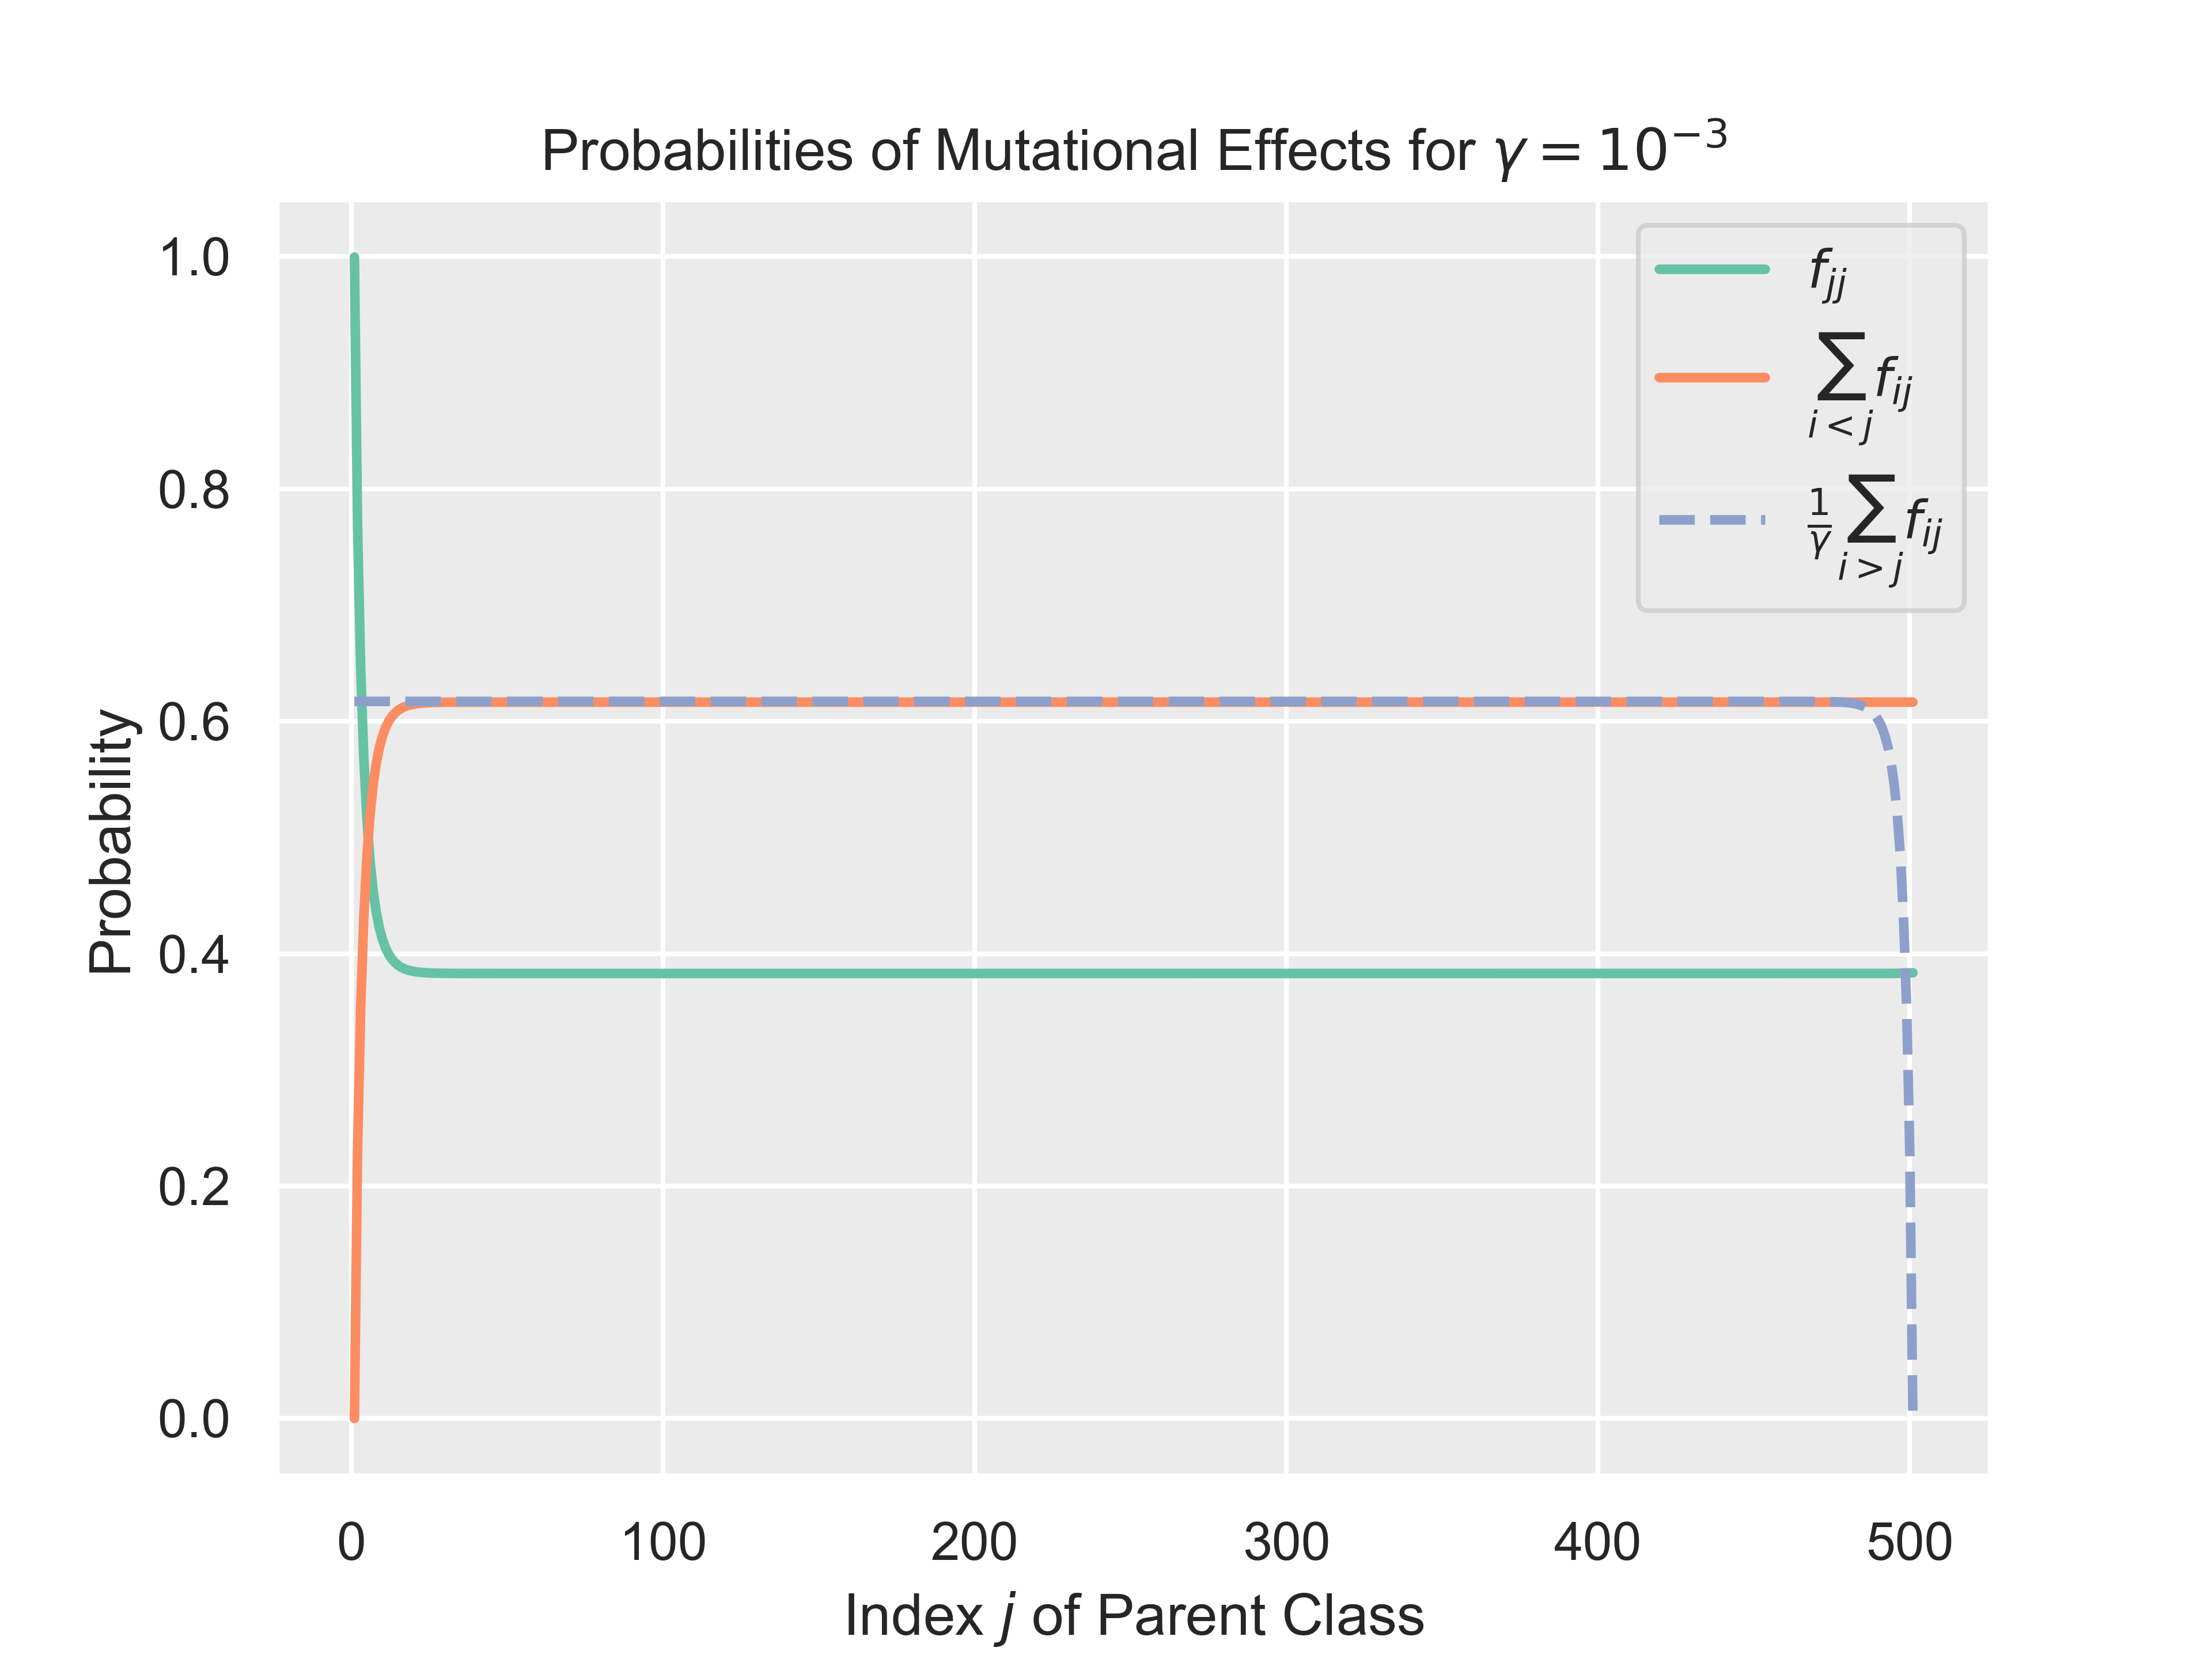

In [4]:
def check_f(gammas):
    """
    Returns an array of f matrices, one for each weight in `gammas`.
    """
    params = [Parameters(gamma=gamma) for gamma in gammas]
    q = np.array([par.q(par.gamma) for par in params])
    f = np.array([par.f(dist) for par, dist in zip(params, q)])
    n = params[0].n
    q0 = q[:,n-1]
    """
    Verify that q(0) does not depend on the mixture weight gamma.
    """
    assert (q0.astype(float) == float(q0[0])).all()
    """
    Verify that f_2,1 == q(w), ..., f_n1 == q((n-1)w) for all instances.
    """
    assert (f[:,1:,0] == q[:,-(n-1):]).all()
    """
    Verify that f_1n == q((1-n)w), ..., f_n-1,n == q(-w) for all
    instances.
    """
    assert (f[:,:-1,-1] == q[:,:n-1]).all()
    """
    Verify that q(w) + ... + q((n-1)w == [1 - q(0)] * gamma for all
    instances.
    """
    q_pos = q[:,-(n-1):].sum(axis=1).astype(float)
    assert (q_pos == ((1 - q0) * gammas).astype(float)).all()
    """
    Verify that q(-w) + ... + q((1-n)w) == [1 - q(0)] * (1 - gamma) for
    all instances.
    """
    q_neg = q[:,:n-1].sum(axis=1).astype(float)
    assert (q_neg == ((1 - q0) * (1 - gammas)).astype(float)).all()
    """
    Report q(0) and 1 - q(0).
    """
    print('For all instances...')
    print('       q(0) ==', float(q0[0]))
    print('   1 - q(0) ==', float(1 - q0[0]))
    return f

def plot_probabilities(f, gamma):
    """
    Plots probabilities of mutational effects for matrix `f`.
    """
    sns.set_palette(sns.color_palette("Set2", 3))
    fig, ax = plt.subplots()
    case = exp_latex(gamma, prefix='\gamma=')
    ax.set_title('Probabilities of Mutational Effects for ' + case)
    ax.set_xlabel('Index $j$ of Parent Class')
    ax.set_ylabel('Probability')
    n = f.shape[0]
    j_range = np.arange(1, n+1)
    f_neg = [f[:j, j].sum() for j in range(n)]
    f_pos = [1 / gamma * f[j+1:, j].sum() for j in range(n)]
    ax.plot(j_range, f[np.diag_indices(n)], label='$f_{jj}$')
    ax.plot(j_range, f_neg, label='$\sum_{i<j} f_{ij}$')
    ax.plot(j_range, f_pos, ls='--', 
            label='$\\frac{1}{\gamma}\sum_{i>j} f_{ij}$')
    ax.legend()
    save_and_display(fig, DIR + 'tmp.png')

f = check_f(mp_float(['1e-3', '1e-6', '1e-9', '1e-12']))
plot_probabilities(f[0], mp_float('1e-3'))

# Results for the modified model

What Basener and Sanford take to be a realistic finite-population model
is a modification of the infinite-population model addressed in the
preceding sections of this notebook. Their description of the modification, in the opening of [Section 5](https://doi.org/10.1007/s00285-017-1190-x#Sec13), is casual:

>In this section we present numerical results for the main system and plot components of the resulting numerical solution to illustrate Theorem [2](https://doi.org/10.1007/s00285-017-1190-x#Equ9) [the Fundamental Theorem of Natural Selection with Mutations]. All plots in this section were created using the online JavaScript page developed for modelling this system (Basener 2013a).
>
>Because the focus of this paper is on implications of the system for biological populations, we make a modification of Eq.&nbsp;([3.2](https://doi.org/10.1007/s00285-017-1190-x#Equ8)) [the main system] that effectively restricts to finite-sized populations. To remain biologically realistic, we assume a finite population: any subpopulation $P_i$ that contains less than some fraction of the population is assumed to contain zero organisms. For the numerical simulations, we set $P_i = 0$ whenever $P_i$ is less than $10^{-9}$ of the total population. This approximates a total population of $10^9$ and eliminates any subpopulation with less than a single organism.

We take Basener and Sanford at their word when they say that they have made a modification of the differential-equation model that they define in Equation 3.2. However, they have not formally modified the definition of the continuous-time system, but instead have described a modification of Basener's discrete-time approximation of it. Clearly, in the modified model, when $P_i(t)$ crosses the threshold $10^{-9} \lVert \mathbf{P}(t) \rVert_1$ from above, and drops instantaneously to zero, the derivative ${\text{d}P_i(t)}/{\text{d}t}$ is undefined. Furthermore, if the derivative of $P_i(t) = 0$ were $\mathbf{w}_i \mathbf{P}(t),$ then the frequency of class $i$ would not rise instantaneously to threshold, but instead would remain zero&nbsp;&mdash; a contradiction. The only consistent definition of the derivative of the frequency of class $i$ is:

\begin{equation*}
   \frac{\text{d}P_i(t)}{\text{d}t}
      = \begin{cases}
            \mathbf{w}_i \mathbf{P}(t) &\text{ if } P_i(t) \geq 10^{-9} \lVert \mathbf{P}(t) \rVert_1 \\
            0 & \text{ if } P_i(t) = 0.
        \end{cases}
\end{equation*}

Rather than invite argument on this point, we show that when the discrete-time approximation of the continuous-time system is sufficiently accurate, frequencies of zero do not change, but instead remain zero forever. We demonstrate also that the numerical results reported by Basener and Sanford in [Section 5.4](https://doi.org/10.1007/s00285-017-1190-x#Sec17) of their article seem reasonable only because they are grossly inaccurate.

## Numerical solution of the modified model

Given the initial frequencies $\mathbf{P}(0),$ one may use the forward Euler method of numerical integration to solve for frequencies in the infinite-population model: set the initial solution $\mathbf{s}_0 = \mathbf{P}(0),$ and then iterate

$$\mathbf{s}_{k+1} \leftarrow \mathbf{s}_{k} + h \:\! W \mathbf{s}_k,$$

where scalar $h > 0$ is the step size, and $\mathbf{s}_k$ is the solution for frequencies $\mathbf{P}(k\:\!h).$ That is, for all non-negative integers $k,$ $\mathbf{s}_k$ is an approximation of the frequencies $\mathbf{P}(t)$ at time $t = k\:\!h.$ The accuracy of the approximation increases as the step size $h$ decreases, provided that calculations are performed with sufficient numerical precision. In iteration $k+1,$ there are $h \:\! d \:\! \lVert \mathbf{s}_k \rVert_1$ deaths, and at most $h \:\! b_n \:\! \lVert \mathbf{s}_k \rVert_1$ births. If $s_{k,i} = 0,$ then the relative frequency of class $i$ in iteration $k+1$ is maximal when the number of  births is maximal, and all of the births belong to class $i$:

\begin{align*}
   \frac{s_{k+1,i}}{\lVert \mathbf{s}_{k+1} \rVert_1}
   &\leq \frac{h \:\! b_n \:\! \lVert \mathbf{s}_k \rVert_1 }
             {\lVert \mathbf{s}_k \rVert_1
         + h \:\! b_n \:\! \lVert \mathbf{s}_k \rVert_1 
         - h \:\! d \:\! \lVert \mathbf{s}_k \rVert_1} \\
   &= \frac{h \:\! b_n}
           {h \:\! (b_n - d) + 1}.
\end{align*}

Note that the right-hand side tends to zero as the step size $h$ tends to zero.

As shown in Supporting Materials 3, Basener uses the Euler method, with $h=1,$ to solve for frequencies in the infinite-population model. To solve for frequencies in the modified model, he extends the method to zero elements of $\mathbf{s}_{k+1}$ that fall below threshold:

\begin{align*}
   \mathbf{s}_{k+1} &\leftarrow \mathbf{s}_{k} + h \:\! W \mathbf{s}_k \\
   s_{k+1,i} &\leftarrow 0 \text{ for all } i \text{ such that } 
           \textstyle{\frac{s_{k+1,i} }{ \lVert\mathbf{s}_{k+1}\rVert_1} < \theta  ,}
\end{align*}

with threshold relative frequency $\theta = 10^{-9}\!.$ (Basener erroneously puts $\lVert\cdot\rVert_\infty$ in place of $\lVert\cdot\rVert_1$ in the calculation of relative frequencies.) However, if the step size $h$ is sufficiently small, which is to say, if solutions are sufficiently accurate, then 

\begin{equation*}
    \frac{s_{k+1,i} }{ \lVert\mathbf{s}_{k+1}\rVert_1}
    \leq \frac{h \:\! b_n} {h \:\! (b_n - d) + 1} < \theta
\end{equation*}

whenever $s_{k,i}$ is zero. Thus, in the continuous-time system approximated by the solution procedure, a frequency of zero never changes. The procedure errs categorically in cases where $s_{k,i} = 0$ and $s_{k+1,i} > 0.$ 

We emend the solution procedure by zeroing $\mathbf{w}_i,$ the $i$-th row of the derivative operator $W\!,$ when the calculated frequency of class $i$ is zero:

\begin{align*}
   \mathbf{w}_i &\leftarrow [0, 0, \dotsc, 0]  \text{ for all } i \text{ such that } s_{k, i} = 0 \\
   \mathbf{s}_{k+1} &\leftarrow \mathbf{s}_{k} + h \:\! W \mathbf{s}_k \\
   s_{k+1,i} &\leftarrow 0 \text{ for all } i \text{ such that } s_{k+1,i} < \theta \:\! \lVert\mathbf{s}_{k+1}\rVert_1 .
\end{align*}

With this change, the derivative of a frequency of zero is zero. We also set initial frequencies to zero if they are below threshold:

\begin{align*}
   \mathbf{s}_0 &\gets \mathbf{P}(0) \\
   s_{0,i} &\gets 0 \text{ for all } i \text{ such that }
             s_{0,i} < \theta  \lVert\mathbf{s}_{0}\rVert_1 .
\end{align*}

It follows by a simple inductive argument that if $s_{k,i} = 0,$ then $s_{k^\prime\!,i} = 0$ for all integers $k^\prime > k.$

The Python class `Solver`, defined in the following code cell, implements the emended solution procedure. Its `_zero` method zeroes subthreshold frequencies and corresponding rows of the derivative operator. The subclass `PoorSolver` of class `Solver` overrides the `_zero` method, and zeroes only subthreshold frequencies. It is otherwise identical to `Solver`.

In [5]:
# %load './Code/solver.py'
class Solver(object):
    """
    A solver for relative frequencies in the modified model.
    
    A modification of the forward Euler method of numerical integration
    is applied. Solutions for relative frequencies are set to zero when
    they fall below a given threshold, and subsequently are held at zero.
    Only end-of-year solutions are stored, beginning with the solution
    for year 0 (derived from the given initial frequencies). Note that 
    solutions for the infinite-population model can be obtained by
    setting the threshold to zero.
    
    The solver is run by calling this object. Each call extends the 
    solutions by a given number of years. The end-of-year solutions are
    retrieved by indexing this object.
    """ 
    def __init__(self, W, initial_freqs, log_steps_per_year=10,
                       threshold=1e-9):
        """
        Initialize the solver.
        
        Parameter `W` is a derivative matrix operator. The value of
        `log_steps_per_year` must be a non-negative integer. When the
        solver is run, there are `2 ** log_steps_per_year` integration
        steps  per year. The step size is the reciprocal of the number
        of steps per year.
        
        The solution for year 0 is `initial_freqs` with frequencies
        less than `threshold` times the sum of the initial frequencies
        set to zero.
        """
        self.W = np.array(W)
        assert type(log_steps_per_year) is int
        assert log_steps_per_year >= 0
        self.steps_per_year = 2 ** log_steps_per_year
        self.step_size = 1 / self.steps_per_year
        self.threshold = threshold
        #
        # Array `s` always contains the latest solution for frequencies
        # of classes, scaled by `2**s_bias` to avoid overflow and
        # underflow in calculations. The setting of `max_exponent`,
        # which specifies the exponent of the maximum element of `s`, 
        # is small enough to ensure that the sum of squared elements of
        # `s` can be calculated with 64-bit floats. The base type of
        # `s` is that of `initial_freqs`.
        self.s = np.array(initial_freqs)
        self.max_exponent = 510 - math.ceil(math.log2(len(self.s)))
        self.s_bias = bias_exponents(self.s, self.max_exponent)
        #
        # Zero initial frequencies that are below threshold.
        self._zero()
        #
        # Array `solutions` contains the solutions for end-of-year
        # relative frequencies of classes. The base type is float. There
        # is one row for each year.
        self.n_solutions = 1
        self.solutions = np.empty((self.n_solutions, len(self.s)))
        self.solutions[0] = self.s / fsum(self.s)

    def _zero_subthreshold_frequencies(self):
        """
        Zeroes calculated frequencies that are below threshold.
        
        Returns a Boolean array indicating which frequencies are zero.
        """
        # Determine which calculated frequencies are below threshold.
        # The array `subthreshold` contains Boolean values.
        subthreshold = self.s < self.threshold * self.s.sum()
        #
        # Using Boolean indexing, zero the subthreshold elements of `s`.
        self.s[subthreshold] = 0.0
        return subthreshold
        
    def _zero(self):
        """
        Zeroes subthreshold calculated frequencies and their derivatives.
        """
        if self.threshold > 0.0:
            # Array `zeroed` indicates which calculated frequencies are
            # zero. Rows of the derivative operator `W` corresponding to
            # zeroed frequencies are zeroed.
            zeroed = self._zero_subthreshold_frequencies()
            self.W[zeroed,:] = 0.0
        
    def __call__(self, n_years=1000):
        """
        Solve for `n_years` end-of-year relative frequencies.
        """
        # Extend the `solutions` array to hold an additional `n_years`
        # solutions for end-of-year relative frequencies.
        self._extend_storage(n_years)
        #
        for _ in range(n_years):
            # Perform `steps_per_year` numerical integration steps.
            for _ in range(self.steps_per_year):
                # Multiply derivative operator `W` by the calculated
                # frequencies `s` to obtain derivatives of frequencies.
                # Scale the derivatives by the step size, and add the
                # result to `s`.
                self.s += self.step_size * (self.W @ self.s)
                #
                # Zero subthreshold elements of `s`. Derivatives of
                # zeroed frequencies are set to zero unless the `_zero`
                # method is overridden.
                self._zero()
            # Bias exponents of the current solution to avoid overflow
            # and underflow. Keep track of the cumulative bias.
            self.s_bias += bias_exponents(self.s, self.max_exponent)
            #
            # Store the solution for end-of-year relative frequencies.
            self.solutions[self.n_solutions] = self.s / fsum(self.s)
            self.n_solutions += 1

    def get_last_solution(self):
        """
        Returns unnormalized solution for frequencies in the last year.
        
        The elements of the returned array are multiprecision floats.
        """
        return mp.mpf(2.0)**-self.s_bias * self.s

    def __getitem__(self, key):
        # Returns the result of indexing end-of-year solutions by `key`.
        return self.solutions[key]

    def __len__(self):
        # Returns the number of stored solutions (one per year).
        return len(self.solutions)

    def _extend_storage(self, n):
        # Allocate storage for solutions for an additional `n` years.
        rows, cols = self.solutions.shape
        new = np.zeros((rows+n, cols), dtype=float)
        new[:rows] = self.solutions
        self.solutions = new

        
class PoorSolver(Solver):
    """
    A poor solver for frequencies in the modified model.
    """
    def _zero(self):
        """
        Zeroes calculated frequencies that are below threshold.
        
        Derivatives of zeroed frequencies are NOT set to zero.
        """
        if self.threshold > 0.0:
            self._zero_subthreshold_frequencies()

## Run the good and poor solvers

What we refer to as the good solver and the poor solver are identically initialized instances of, respectively, class `Solver` and class `PoorSolver`. As explained above, the classes differ only in implementation of the `_zero` method. The maximum fitness is $m_n = 0.1,$ and the weighting of beneficial mutational effects is $\gamma = 10^{-3}.$ Both solvers execute $2^7 =128$ integration steps per year. That is, the step size is $h = 1/128.$

In [6]:
%%time
def solver_setup(params, log_steps_per_year=7, threshold=1e-9):
    """
    Returns identically initialized `Solver` and `PoorSolver` instances.
    """
    W = params.W.astype(float)
    initial_freqs = params.initial_freqs().astype(float)
    args = (W, initial_freqs, log_steps_per_year, threshold)
    return Solver(*args), PoorSolver(*args)

params = Parameters(b_max=0.2, gamma='1e-3')
good_solver, poor_solver = solver_setup(params)
good_solver(n_years=30000)
poor_solver(n_years=30000)

CPU times: user 49min 37s, sys: 2min 33s, total: 52min 10s
Wall time: 14min 50s


### Plot solutions in selected years

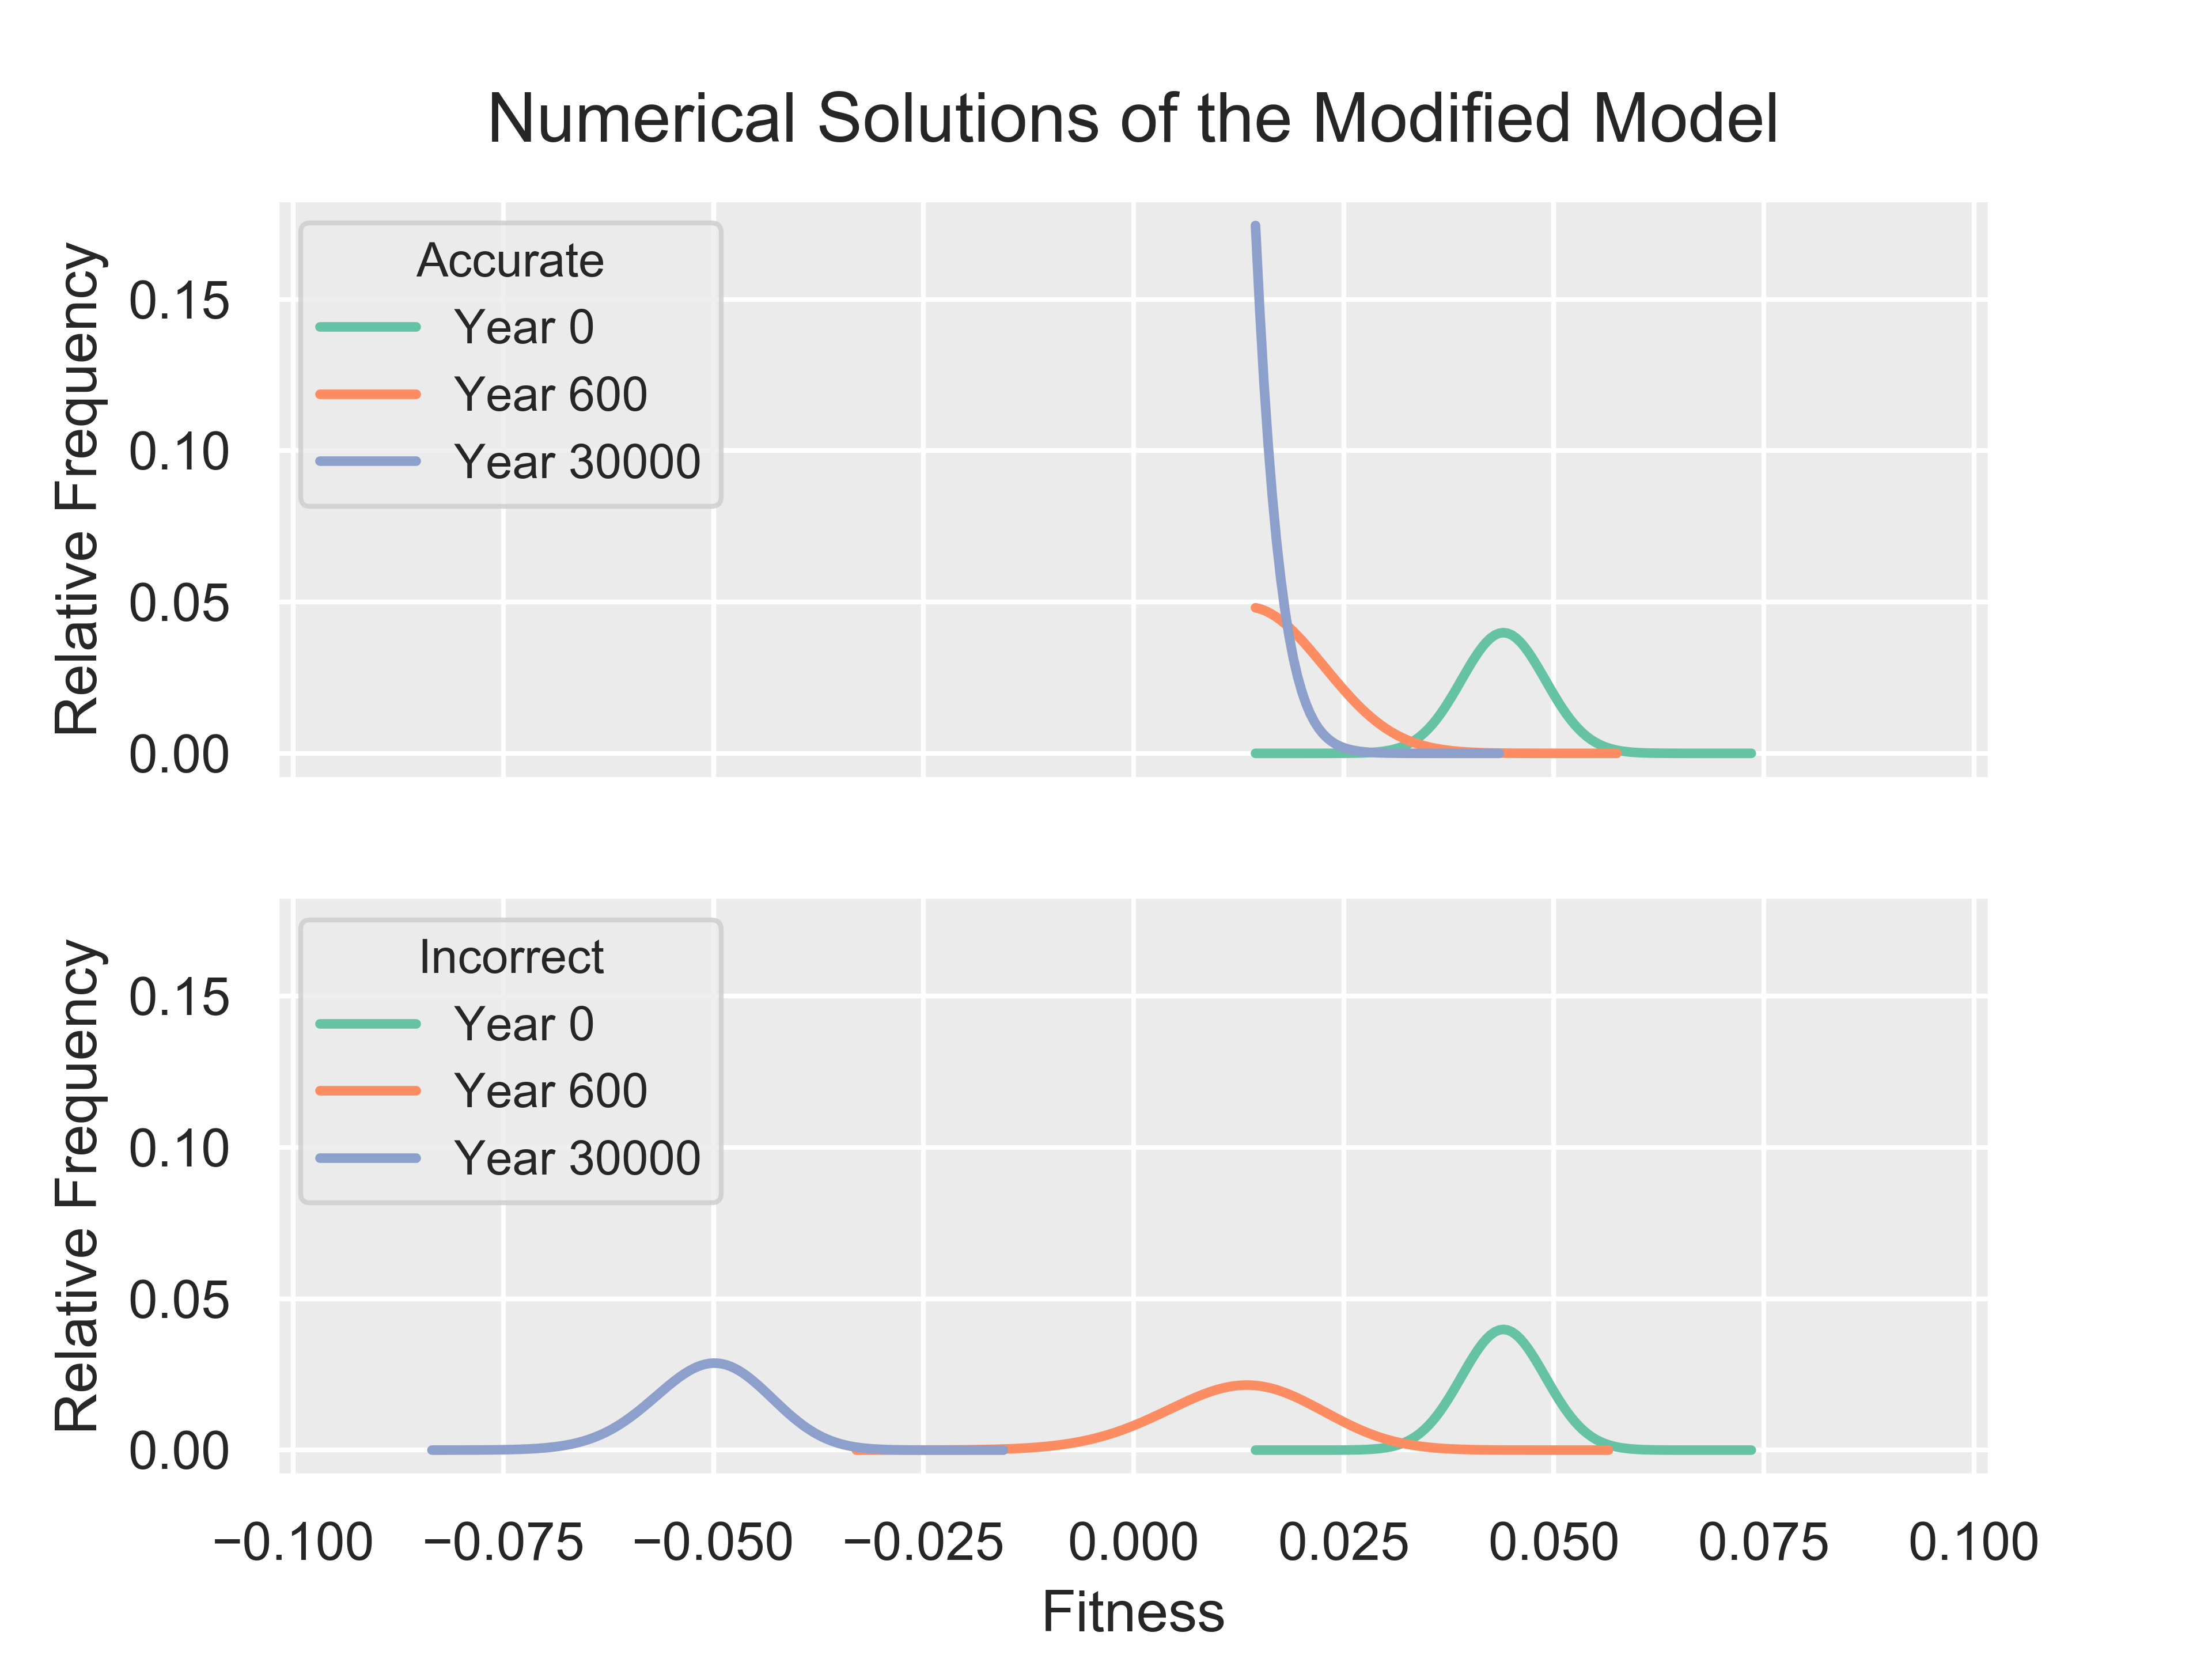

In [7]:
"""
Generate Figure 1 of the article.
"""
intermediate_year = 600

# Set up two subplots, one below the other. Plot solutions for the
# good (poor) solver in the upper (lower) subplot.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
bs_plot(good_solver, params.m, intermediate_year, ax=ax1)
bs_plot(poor_solver, params.m, intermediate_year, ax=ax2)

ax1.set_title('Numerical Solutions of the Modified Model',
              size='large', pad=12)
ax2.set_xlim(-0.102, 0.102)
ax1.set_xlim(-0.102, 0.102)
ax1.set_xlabel(None)
ax1.legend(loc='upper left', fontsize='small', title='Accurate',
           title_fontsize='small')
ax2.legend(loc='upper left', fontsize='small', title='Incorrect',
           title_fontsize='small')
save_and_display(fig, DIR + 'Fig1.png')

# Results for the infinite-population model

Basener and Sanford note in Section 4 that solutions are "asymptotic to the eigenvector corresponding to the largest eigenvalue of $W\!.$" More specifically, with $W$ defined as it is here, the *relative* frequencies converge to an equilibrium:

$$ \lim_{t \rightarrow \infty} 
      \frac{ \mathbf{P}(t)  }
           { \lVert \mathbf{P}(t) \rVert_1  } \rightarrow \mathbf{v},$$

where the equilibrium distribution $\mathbf{v}$ is an eigenvector associated with the largest real eigenvalue of matrix $W\!.$ To be clear, the equilibrium distribution does not depend on the initial frequency distribution. (Exception: If $P_i(0) > 0$ only for class $i=1,$ which has a birth rate of zero, then relative frequencies do not converge to $\mathbf{v}.$) We examine the equilibrium distribution for various weightings of beneficial mutational effects and upper limits on fitness.

## Calculation of eigenvectors

The `equilibrium` function, defined in the following code cell, uses a standard routine in the Scientific Python (SciPy) package to obtain a first approximation of an eigenvector corresponding to the largest real eigenvector of the derivative operator. It then uses the [inverse power method](https://en.wikipedia.org/wiki/Inverse_iteration) to improve the approximation. For an approximation $\tilde{\mathbf{v}}$ of the eigenvector (a column vector), the associated eigenvalue is approximated as the Rayleigh quotient:

\begin{equation*}
    \tilde{\alpha} = 
       \frac{ \tilde{\mathbf{v}}^t W \tilde{\mathbf{v}} }
            { \tilde{\mathbf{v}}^t  \tilde{\mathbf{v}} }.
\end{equation*}
       
For the eigenpair $(\alpha, \mathbf{v})$ approximated by $(\tilde{\alpha}, \tilde{\mathbf{v}}),$ the equality $\alpha \:\! \mathbf{v} = W \mathbf{v}$ holds. Our measure of error in the approximation $(\tilde{\alpha}, \tilde{\mathbf{v}})$ is the maximum absolute error of $\tilde{\alpha} \tilde{\mathbf{v}}$ relative to $W \tilde{\mathbf{v}},$

\begin{equation*}
   \text{mare}(\tilde{\alpha} \tilde{\mathbf{v}}, W \tilde{\mathbf{v}})
      = \max_i \left| 
               \frac{\alpha\tilde{v}_i  
                       - \mathbf{w}_i \tilde{\mathbf{v}}}
                    {\mathbf{w}_i \tilde{\mathbf{v}} } 
               \right|,
\end{equation*}

calculated under the assumption that the scalar $\mathbf{w}_i \tilde{\mathbf{v}} \neq 0$ for all $i.$ (Recall that $\mathbf{w}_i$ denotes the $i$-th row of $W.$)

In [8]:
# %load ./Code/eigen.py
from scipy import linalg
import warnings


def largest_real_eig(W):
    """
    Returns largest real eigenvalue of `W` and an associated eigenvector.
    
    The eigenpair is obtained using the `eig` function in the SciPy
    linear algebra package, which requires that square matrix `W`
    contain 64-bit floats. The largest-magnitude element of the returned
    eigenvector is positive.
    """
    # Use the `eig` function of SciPy's linear algebra package to obtain
    # all eigenvalues and eigenvectors of `W`. Ignore eigenvalues with
    # nonzero imaginary parts, and also their associated eigenvectors.
    e_values, e_vectors = linalg.eig(W)
    real = e_values.imag == 0
    e_values = e_values[real]
    e_vectors = e_vectors[:,real]
    #
    # Select the largest real eigenvalue and its associated eigenvector.
    largest = np.argmax(e_values.real)
    e_value = e_values[largest].real
    e_vector = e_vectors[:,largest].real
    #
    # Negate eigenvector if its largest-magnitude element is negative.
    max_mag = np.argmax(np.abs(e_vector))
    if e_vector[max_mag] < 0:
        e_vector = -e_vector
    return e_value, e_vector


def equilibrium(W, n_iterations=10):
    """
    Finds the equilibrium distribution for derivative operator `W`.
        
    Returns 
    * the largest real eigenvalue `e_value` of square array `W`,
    * the corresponding eigenvector `v` with elements summing to 1, and
    * the maximum absolute error of `e_value * v` relative to `W @ v`.
        
    The eigenpair is initially approximated using `largest_real_eig`.
    The approximation is subsequently improved by performing at most
    `n_iterations` iterations of the inverse power method. 
    """
    # Get a first approximation of the largest real eigenvalue and an
    # associated eigenvector.
    e_value, e_vector = largest_real_eig(W)
    #
    # All elements of the correct eigenvector are positive. Zero the 
    # negative elements of the approximate eigenvector, and recalculate
    # the eigenvalue, along with the approximation error.
    e_vector[e_vector < 0.0] = 0.0
    e_vector /= fsum(e_vector)
    best_e_vector = e_vector
    best_e_value, best_error = rayleigh_quotient(W, best_e_vector)
    #
    # Improve the approximate eigenpair by the inverse power method
    # (see Wikipedia, https://en.wikipedia.org/wiki/Inverse_iteration).
    # The method fails if subtracting the approximate eigenvalue from
    # the main diagonal of `W` produces a singular matrix. 
    A = np.array(W)
    diag_indices = np.diag_indices(A.shape[0])
    A[diag_indices] -= best_e_value
    for _ in range(n_iterations):
        # Solve for a better approximation of the eigenvector. Ignore
        # warnings about possible numerical inaccuracy, and quit the
        # iteration on exception (presumably due to singular `A`).
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                e_vector = linalg.solve(A, e_vector)
            except:
                break
        # Calculate the associated eigenvalue and approximation error
        # for the new approximation of the eigenvector.
        e_vector /= fsum(e_vector)
        e_value, error = rayleigh_quotient(W, e_vector)
        #
        # If the approximation error is the least so far, then use the
        # eigenvalue to recalculate `A`.
        if error < best_error:
            best_error = error
            best_e_value = e_value
            best_e_vector = e_vector
            A[diag_indices] = W[diag_indices] - best_e_value
    return best_e_value, best_e_vector, best_error


def rayleigh_quotient(W, v):
    """
    Calculates the Rayleigh quotient of square matrix `W` and vector `v`.
    
    Returns
    * the Rayleigh quotient `e_value` (the approximate eigenvalue
      corresponding to approximation `v` of an eigenvector of `W`)
    * the maximum absolute error of `e_value * v` relative to `W @ v`,
      the matrix product of `W` and `v`
    
    Assumption: The elements of `W @ v` are all nonzero.
    """
    # Numerical accuracy is crucial, so we calculate the vector dot
    # product using the stable `fsum` to sum the elements of the
    # pointwise product of two vectors.
    def dot(u, v):
        return fsum(u * v)
    #
    # The Rayleigh quotient is (v.T @ W @ v) / (v.T @ v). 
    Wv_product = np.array([dot(row, v) for row in W])
    e_value = dot(v, Wv_product) / dot(v, v)
    #
    # Calculate the maximum absolute relative error, assuming that all
    # elements of `Wv_product` are nonzero. NumPy will issue a warning
    # if any of the elements are zero.
    relative_errors = (e_value*v - Wv_product) / Wv_product
    mare = np.max(np.abs(relative_errors))
    return e_value, mare

## Calculate equilibrium distributions

The class `Equilibria`, defined in the following code cell, stores equilibrium distributions for combinations of values for weighting $\gamma$ of beneficial mutational effects and maximum fitness $m_\text{max}$ in given ranges. The bin width $w$ and death rate $d$ are held constant. For each equilibrium distribution, the mean and variance in fitness of the population is stored.

All of the calculations are done in the initialization method `__init__()`. The bulk of the code generates figures.

In [9]:
# %load ./Code/equilibria.py
from scipy import stats


class Equilibria(object):
    """
    Container for an array of equilibria and associated statistics.
    
    Each row of the array corresponds to a weighting of beneficial
    mutational effects, and each column corresponds to an upper limit
    on fitness.
    
    Equilibria are calculated with death parameter `d` equal to zero. 
    The plotting methods adjust for nonzero `d`.
    """    
    def __init__(self, gammas, b_maxes, Params=Parameters):
        """
        Create array of equilibria, and calculate associated statistics.
        
        Parameters
        * `gammas`: weightings of beneficial mutational effects
        * `b_maxes`: upper limits on the birth parameter
        * `Params`: subclass of `Parameters`
        
        The `gammas` must be integer powers of 2 or 10.
        """
        # Create arrays to hold results, with rows corresponding to
        # probability distributions over mutational effects, and columns
        # corresponding to upper limits on birth parameter.
        m, n = len(gammas), len(b_maxes)
        self.params = np.empty((m, n), dtype=object)
        self.eq = np.empty((m, n), dtype=object)
        self.e_value = np.empty((m, n))
        self.eigen_error = np.empty((m, n))
        self.mean = np.empty((m, n))
        self.var = np.empty((m, n))
        #
        # Calculate equilibria along with means/variances of fitnesses,
        # with death parameter `d` set to zero.
        d = 0
        for i in range(m):
            for j in range(n):
                self.params[i,j] = Params(b_maxes[j], d, gamma=gammas[i])
                m = self.params[i,j].m
                W = self.params[i,j].W.astype(float)
                e_value, e_vector, error = equilibrium(W)
                self.e_value[i,j] = e_value
                self.eq[i,j] = e_vector
                self.eigen_error[i,j] = error
                self.mean[i,j], self.var[i,j] = mean_var(self.eq[i,j], m)

    def plot_stats(self, d='0.1'):
        """
        Plot the means and variances in fitness for all equilibria.
        """
        # Set up two axis systems, one for means, the other for variances.
        sns.set_palette(sns.color_palette("Set2", len(self.mean)))
        fig, ax_m = plt.subplots()
        ax_v = ax_m.twinx()
        ax_v.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_v.grid(False)
        #
        # Plot the means and variances as functions of the upper limit
        # on fitness, row by row. Each row corresponds to a weighting 
        # `gamma` of beneficial mutational effects.
        lims = [float(p.b[-1] - mp_float(d)) for p in self.params[0,:]]
        gammas = [exp_latex(p.gamma, '\gamma=') for p in self.params[:,0]]
        mean = self.mean - float(d)
        for m, v, g in zip(mean, self.var, gammas):
            ax_m.plot(lims, m, label=g, marker='+', ls='none')
            ax_v.plot(lims, v, label=g, marker='o', mfc='none', ls='none')
        #
        # Fit lines to means by linear regression, and plot them.
        xlim = ax_m.get_xlim()
        ylim = ax_m.get_ylim()
        ends = np.array(xlim)
        for means in mean:
            r = stats.linregress(lims, means)
            fitted_line = r.slope*ends + r.intercept
            ax_m.plot(ends, fitted_line, color='k', lw=0.5, zorder=1)
        #
        # Keep the x and y limits where they were prior to plotting
        # the fitted lines.
        ax_m.set_xlim(*xlim)
        ax_m.set_ylim(*ylim)
        #
        # Add title, axis labels, and legends.
        ax_m.xaxis.set_major_locator(plt.MaxNLocator(len(lims)))
        t = 'Linear Relations of Fitness Limit and Equilibrium Moments\n'
        t = t + 'Infinite Population, Beneficial Effects Weight $\gamma$'
        ax_m.set_title(t, size='large', pad=12)
        ax_m.set_xlabel('Upper Limit on Fitness')
        ax_m.set_ylabel('Mean Fitness at Equilibrium')
        ax_v.set_ylabel('Variance in Fitness at Equilibrium')
        ax_m.legend(title='Mean', loc='upper left')
        ax_v.legend(title='Variance', loc='lower right')
        #
        self.fig, self.ax_m, self.ax_v = fig, ax_m, ax_v
    
    def _begin_plot_curves(self, eq):
        # Set up an axis system and a color palette for a plot of
        # equlibria in one row or one column of the array.
        sns.set_palette(sns.color_palette("Set2", len(eq)))
        self.fig, self.ax = plt.subplots()
        self.lines = np.empty(len(eq), dtype=object)
        max_y = max([e.max() for e in eq])
        self.ax.set_ylim([-0.0003, 1.05 * max_y])
        
    def plot_column(self, j, d='0.1'):
        """
        Plot equilibria for `j`-th upper limit on fitness.
        """
        eq = self.eq[:,j]
        params = self.params[:,j]
        fitness = (params[0].b - mp_float(d)).astype(float)
        variable_name = 'Beneficial Effects Weight'
        abbrev_var_name = 'Weight $\gamma$'
        constant_name = 'Fitness Upper Limit {:5.3f}'.format(fitness[-1])
        self._begin_plot_curves(eq)
        for i in range(len(eq)):
            gamma = exp_latex(float(params[i].gamma), '\gamma=')
            self.lines[i], = plt.plot(fitness, eq[i], label=gamma)
        self._finish_plot_curves(variable_name, abbrev_var_name,
                                 constant_name)

    def plot_row(self, i, d='0.1'):
        """
        Plot equilibria for `i`-th weighting of beneficial effects.
        """
        eq = self.eq[i,:]
        params = self.params[i,:]
        gamma = exp_latex(float(params[0].gamma), '\gamma=')
        variable_name = 'Fitness Upper Limit'
        abbrev_var_name = 'Fitness Limit'
        constant_name = 'Beneficial Effects Weight {}'.format(gamma)
        self._begin_plot_curves(eq)
        for j in range(len(eq)):
            fitness = (params[j].b - mp_float(d)).astype(float)
            fitness_limit = '{:5.3f}'.format(fitness[-1])
            self.lines[j], = plt.plot(fitness, eq[j], label=fitness_limit)
            self.lines[j].set_zorder(100 - j)
        self._finish_plot_curves(variable_name, abbrev_var_name,
                                 constant_name)

    def _finish_plot_curves(self, variable_name, abbrev_var_name,
                                  constant_name):
        # Set titles and label axes.
        self.ax.set_ylabel('Relative Frequency')
        self.ax.set_xlabel('Fitness')
        title = 'Dependence of Equilibrium on {}\nInfinite Population, {}'
        title = title.format(variable_name, constant_name)
        self.ax.set_title(title, size='large', pad=12)
        self.ax.legend(title=abbrev_var_name, loc='best')
        self.ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    def save_and_display(self, filename):
        """
        Saves the figure to disk, displays it, and closes the plot.
        """
        save_and_display(self.fig, filename)

    def __getitem__(self, key):
        """
        Returns an equilibrium along with mean and variance.
        """
        return self.eq[key], self.mean[key], self.var[key]

In the following run, the mixture weight $\gamma$ takes values $10^{-3}\!,$ $10^{-6}\!,$ $10^{-9}\!,$ and $10^{-12}\!,$ and the upper limit on fitness $m_\text{max}$ takes values $0.025,$ $0.050, \dotsc,$ $0.200.$ Upon completion, the `Equilibria` object stores a 4-by-9 array of equilibrium distributions, with rows corresponding to mixture weights, and columns corresponding to upper limits on fitness.

In [10]:
%%time

mixture_weights = mp_float(['1e-3', '1e-6', '1e-9', '1e-12'])
birth_rate_limits = mp.linspace(mp_float('0.125'), mp_float('0.3'), 8)
eq = Equilibria(mixture_weights, birth_rate_limits)

CPU times: user 3min 2s, sys: 9.46 s, total: 3min 11s
Wall time: 1min 22s


## Check accuracy of calculated eigenpairs

The following code cell establishes that the maximum absolute relative error $\text{mare}(\tilde{\alpha}\tilde{\mathbf{v}}, W \tilde{\mathbf{v}})$ is very small for all $4 \times 9 = 36$ pairs $(\tilde{\alpha}, \tilde{\mathbf{v}})$ of eigenvalue $\tilde{\alpha}$ and corresponding eigenvector (equilibrium) $\tilde{\mathbf{v}}.$ 

In [11]:
def print_array(a, field_format=' {:4.2e}'):
    for row in a:
        s = field_format * len(row)
        print(s.format(*row))

print('Eigenpair approximation errors:\n')
print_array(eq.eigen_error)
print('\nMax approximation error:', np.max(eq.eigen_error))

Eigenpair approximation errors:

 6.36e-16 5.57e-16 6.02e-16 7.15e-16 8.90e-16 1.04e-15 8.86e-16 6.37e-16
 5.91e-16 5.44e-16 6.41e-16 6.72e-16 4.87e-16 6.58e-16 7.73e-16 6.28e-16
 5.97e-16 4.44e-16 6.38e-16 5.46e-16 6.08e-16 6.35e-16 7.50e-16 6.15e-16
 4.43e-16 6.61e-16 5.84e-16 6.09e-16 6.64e-16 6.84e-16 7.25e-16 7.16e-16

Max approximation error: 1.0370261520032004e-15


## Compare eigenvalues to mean fitnesses

The following code cell establishes that for each calculated eigenpair $(\tilde{\alpha}, \tilde{\mathbf{v}}),$ the mean fitness of the population at equilibrium $\tilde{\mathbf{v}}$ is nearly, if not exactly, equal to the eigenvalue $\tilde{\alpha}$ of the derivative operator. That is, with $\lVert \tilde{\mathbf{v}} \rVert_1 = 1,$

$$\sum_{i=1}^n \tilde{v}_i m_i \approx \tilde{\alpha}.$$

In [12]:
print('Absolute differences of eigenvalues and mean fitnesses:\n')
print_array(np.abs(eq.mean - eq.e_value))
print('\nMax absolute difference:', np.max(np.abs(eq.mean - eq.e_value)))

Absolute differences of eigenvalues and mean fitnesses:

 1.39e-17 1.39e-17 0.00e+00 2.78e-17 0.00e+00 0.00e+00 2.78e-17 0.00e+00
 0.00e+00 0.00e+00 1.39e-17 0.00e+00 0.00e+00 2.78e-17 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 1.39e-17 0.00e+00 1.39e-17 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.39e-17 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.78e-17 0.00e+00

Max absolute difference: 2.7755575615628914e-17


## Plot selected results

In the following figure, mean fitness and variance in fitness are plotted for each of the 36 equilibrium distributions. Lines are fitted to mean fitnesses by linear regression of mean fitnesses on maximum fitnesses.

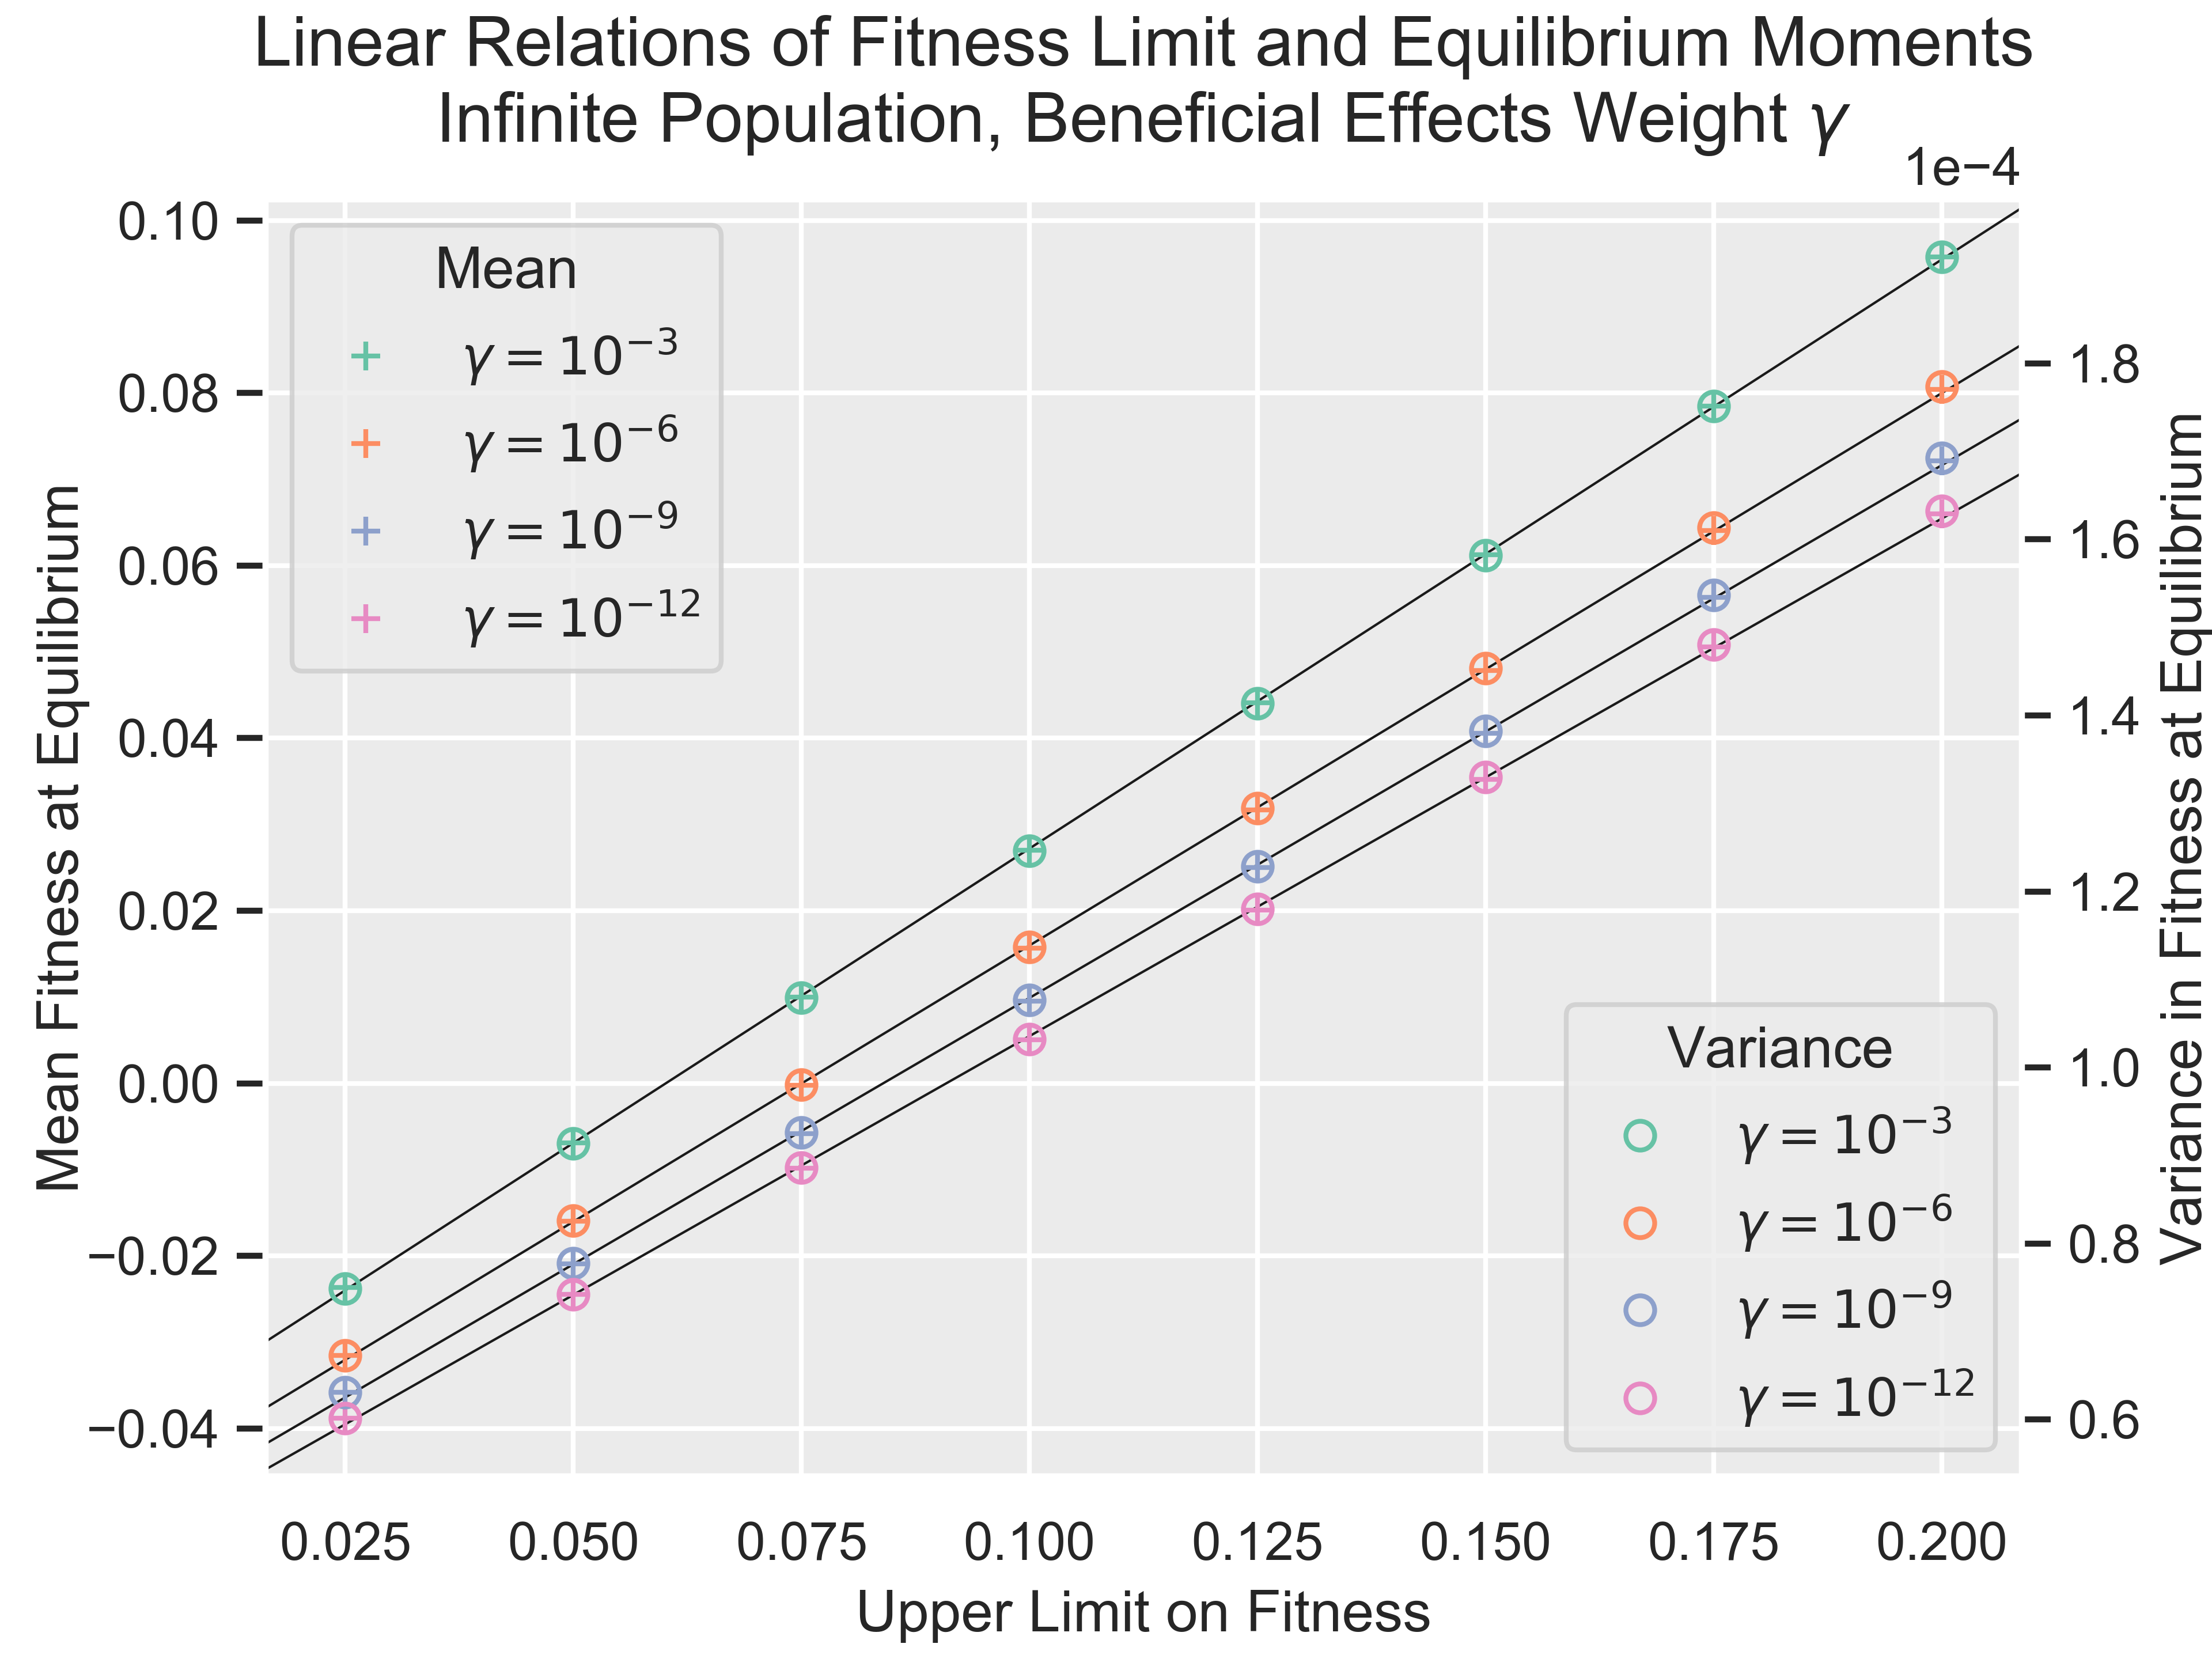

In [13]:
"""
Generate Figure 2 of the article.
"""
eq.plot_stats()
eq.ax_m.yaxis.set_label_coords(-0.1, 0.5)
eq.fig.subplots_adjust(left=0.12, right=0.914)
eq.save_and_display(DIR + 'Fig2.png')

In the following figure, equilibrium distributions corresponding to the fourth column of dots in the figure above are plotted. That is, the upper limit on fitness is held at 0.1, and the weighting of beneficial mutational effects ranges from $10^{-3}$ to $10^{-12}.$

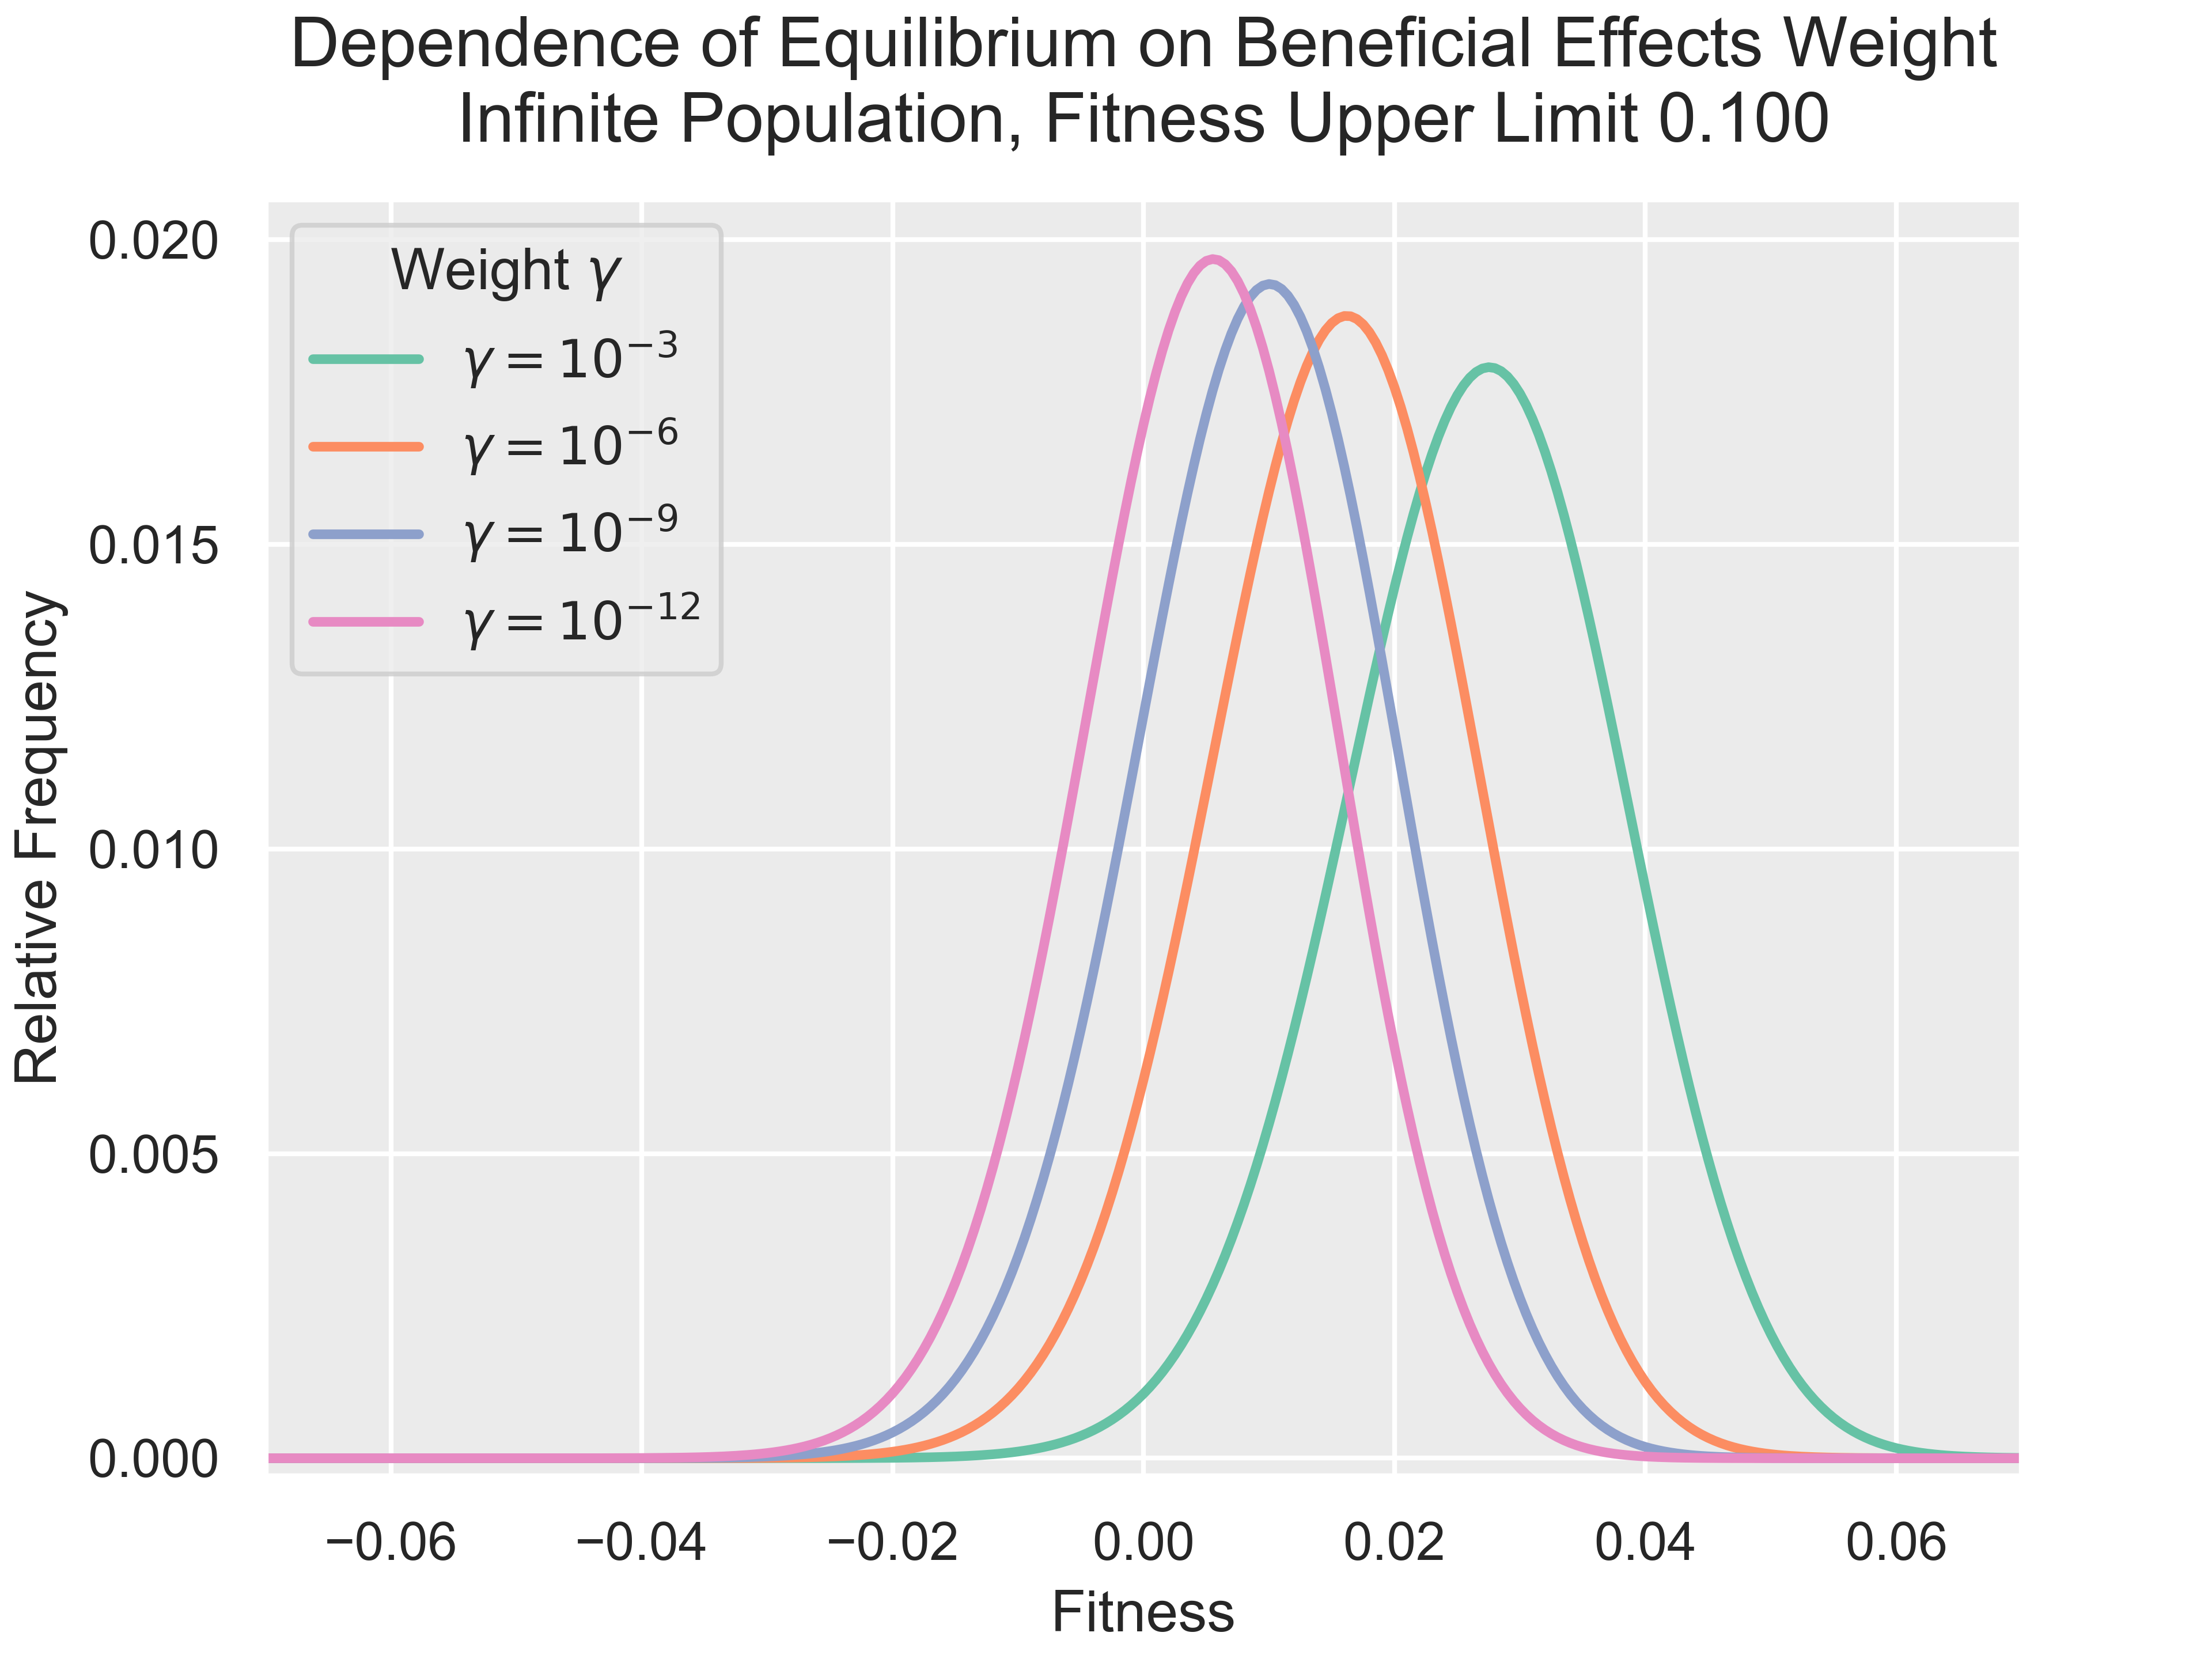

In [14]:
"""
Generate Figure 3 of the article.
"""
eq.plot_column(3)
eq.ax.set_xlim([-0.07, 0.07])
eq.fig.subplots_adjust(left=0.12, right=0.914)
eq.save_and_display(DIR + 'Fig3.png')

In the following figure, the weighting of beneficial mutational effects is held at $10^{-6},$ and the upper limit on fitness ranges from $0.025$ to $0.2.$

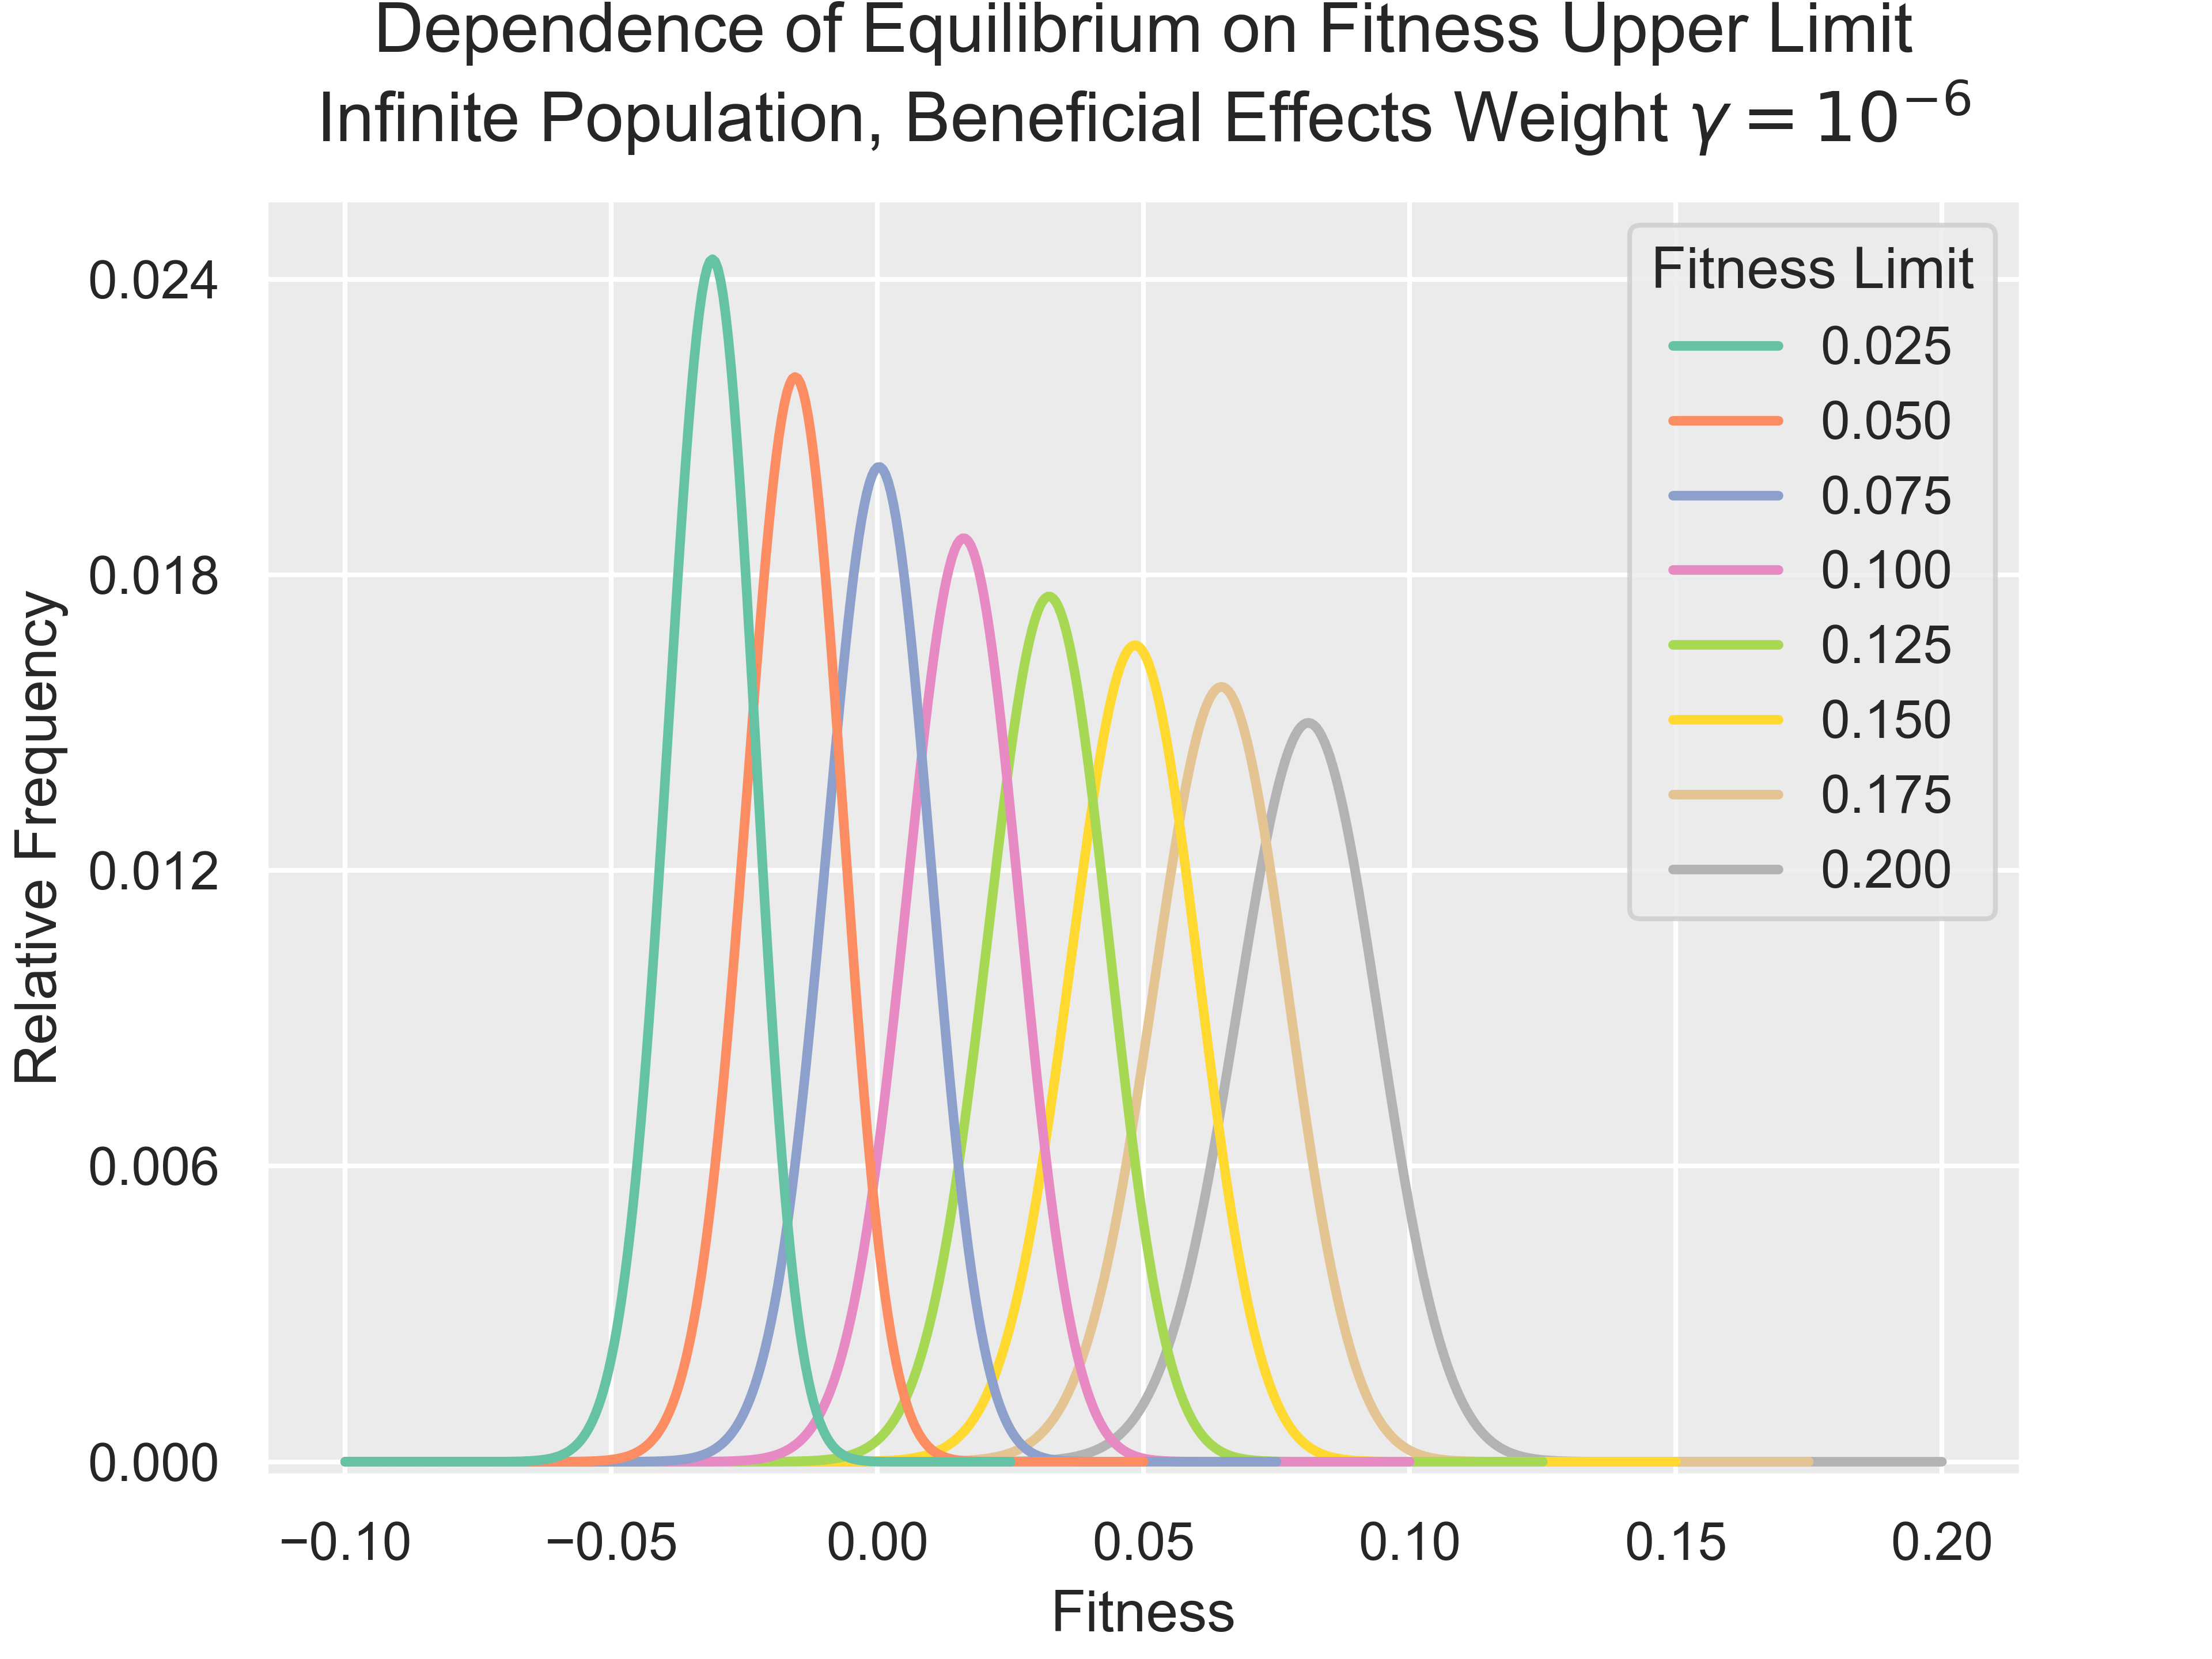

In [15]:
"""
Generate Figure 4 of the article.
"""
eq.plot_row(1)
eq.fig.subplots_adjust(left=0.12, right=0.914)
eq.save_and_display(DIR + 'Fig4.png')

# Appendix: Array processing

**Create an array of evenly spaced values**

The arguments to NumPy `linspace(a, b, n)` are the least value `a`, the greatest value `b`, and the number `n` of values.

In [16]:
"""
With 5 evenly spaced values ranging from 0 to 1, the differences are 1/4.
"""
a = np.linspace(0, 1, 5)
a

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

**Multiplication of a scalar and an array**

Each element of the array is multiplied by the scalar. The result is a new array.

In [17]:
4 * a

array([0., 1., 2., 3., 4.])

**Subtraction of a scalar from an array of numbers**

The scalar is subtracted from each element of the array. The result is a new array.

In [18]:
"""
Subtract scalar 1/4 from the array `a` we just created. The result has
the same shape as `a`.
"""
b = a - 1/4
b

array([-0.25,  0.  ,  0.25,  0.5 ,  0.75])

**Subtraction of an array from an array**

When the arrays are identical in shape, the subtraction operation is pointwise. The result is a new array.

In [19]:
"""
Subtract array `b` from array `a`, where the two arrays are identical
in shape. The result `diff` is identical in shape to the operands.
"""
diff = a - b
diff

array([0.25, 0.25, 0.25, 0.25, 0.25])

**Copying an array**

In [20]:
c = np.array(a)
print('Array a:', a)
print('Array c:', c)

Array a: [0.   0.25 0.5  0.75 1.  ]
Array c: [0.   0.25 0.5  0.75 1.  ]


**In-place addition of an array to an array**

In [21]:
"""
Add array [0, 1, 2, 3, 4] to array `c`.
"""
c += np.linspace(0, 4, 5)
"""
Verify that `c`, and not `a`, is changed.
"""
print('Array a:', a)
print('Array c:', c)

Array a: [0.   0.25 0.5  0.75 1.  ]
Array c: [0.   1.25 2.5  3.75 5.  ]


**Comparison of array elements to a scalar**

The result is an array of Boolean values.

In [22]:
a == 0.25

array([False,  True, False, False, False])

**Comparison of corresponding elements of two arrays**

In [23]:
c > a

array([False,  True,  True,  True,  True])

In [24]:
c >= a

array([ True,  True,  True,  True,  True])

**Testing whether all of the elements in an array are true**

In [25]:
(c > a).all()

False

In [26]:
(c >= a).all()

True

**Indexing an array**

Indexing is zero-based. Negative indices are added to the length `len(a)` of the 1-D array `a`.

In [27]:
a[-4]

0.25

In [28]:
a[-4] == a[len(a)-4]

True

**Slicing an array**

For non-negative indices `m` and `n`, slice `a[m:n]` is a reference to `n - m` elements of 1-D array `a`, starting with element `a[m]`, and ending with element `a[n-1]`.

In [29]:
a[1:4]

array([0.25, 0.5 , 0.75])

Negative indices are added to `len(a)`, the number of elements in 1-D array `a`.

In [30]:
"""
Start at the first element, and stop at (exclude) the last element.
"""
a[0:-1]

array([0.  , 0.25, 0.5 , 0.75])

In [31]:
"""
Start with the fourth element, counting from end, and stop at 
(exclude) the last.
"""
a[-4:-1]

array([0.25, 0.5 , 0.75])

In [32]:
"""
Verify that negative indices are added to the number of elements in
the array.
"""
n = len(a)
(a[-4:-1] == a[n-4:n-1]).all()

True

Slice `a[:n]` is equivalent to `a[0:n]`, and slice `a[m:]` is equivalent to `a[m:len(a)]`.

In [33]:
"""
Exclude the first two elements.
"""
a[2:]

array([0.5 , 0.75, 1.  ])

In [34]:
"""
Include only the last two elements.
"""
a[-2:]

array([0.75, 1.  ])

In [35]:
"""
Exclude the last two elements.
"""
a[:-2]

array([0.  , 0.25, 0.5 ])

Slice `a[::-1]` is a reference to array `a` in reverse.

In [36]:
a[::-1]

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

**Differencing an array**

Subtract the slice excluding the last element from the slice excluding the first element of the array.

In [37]:
"""
Square the first ten of the non-negative integers.
"""
squares = np.linspace(0, 9, 10) ** 2
"""
Subtract the slice excluding the first of the squares from the slice
excluding the last of the squares. The result is the first nine of the
positive odd integers.
"""
odd_numbers = squares[1:] - squares[:-1]
print('Squares                :', squares)
print('Differences of squares :', odd_numbers)

Squares                : [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
Differences of squares : [ 1.  3.  5.  7.  9. 11. 13. 15. 17.]


**Creating an uninitialized square matrix**

In [38]:
"""
The default type of elements of the matrix is float, but here we
specify the type explicitly.
"""
M = np.empty((3, 3), dtype=float)

**Assigning a 1-D array to a column of a 2-D array**

The number of elements in the 1-D array must match the number of rows in the 2-D array.

In [39]:
M[:,0] = squares[0:3]
M[:,1] = squares[3:6]
M[:,2] = squares[6:9]
M

array([[ 0.,  9., 36.],
       [ 1., 16., 49.],
       [ 4., 25., 64.]])

**Matrix multiplication**

For 2-D array `M` and 1-D array `v`, multiplication `M * v` scales the columns of array `M` by the corresponding elements of `v`, resulting in an array of the same shape as `M`. Matrix multiplication `M @ v` treats `M` as a matrix and `v` as a column vector, and results in a 1-D array. That is, `M @ v` is the sum of the columns in `M * v`.

In [40]:
"""
Create array v = [0, 0.5, 1].
"""
v = np.linspace(0, 1, 3)
"""
Matrix product `M @ v` is the sum of the columns in matrix `M * v`.
"""
M * v, M @ v, (M * v).sum(axis=1)

(array([[ 0. ,  4.5, 36. ],
        [ 0. ,  8. , 49. ],
        [ 0. , 12.5, 64. ]]),
 array([40.5, 57. , 76.5]),
 array([40.5, 57. , 76.5]))

In [41]:
"""
Indicate when this code cell was last executed.
"""
print("Time stamp:", datetime.now())

Time stamp: 2020-06-24 00:29:44.349254
